
[MODELS_TO_RUN]
 - classic_elasticnet
 - bagging_extratrees
 - boosting_model
 - mlp_regressor
Akima interpolation hourly → 15-min for column: pressure_msl
Akima interpolation hourly → 15-min for column: surface_pressure
Akima interpolation hourly → 15-min for column: cloud_cover
Akima interpolation hourly → 15-min for column: cloud_cover_low
Akima interpolation hourly → 15-min for column: cloud_cover_mid
Akima interpolation hourly → 15-min for column: cloud_cover_high
Akima interpolation hourly → 15-min for column: vapour_pressure_deficit
Master DF shape: (125951, 40)
Remaining days after cleaning: 1306
Removed days: 6
Total days: 1306
Ratios -> Train: 0.80, Val: 0.05, Test: 0.15
Split  -> Train days: 1044, Val days: 65, Test days: 197
Train shape: (100224, 46)
Val   shape: (6240, 46)
Test  shape: (18912, 46)

===== FEATURE SELECTION (Two-stage: Relevance -> Clustering) =====
TOP_K_FEATS=5 | selected=5
Selected features:
['global_tilted_irradiance (W/m²)', 'vapour_pressure_deficit', 

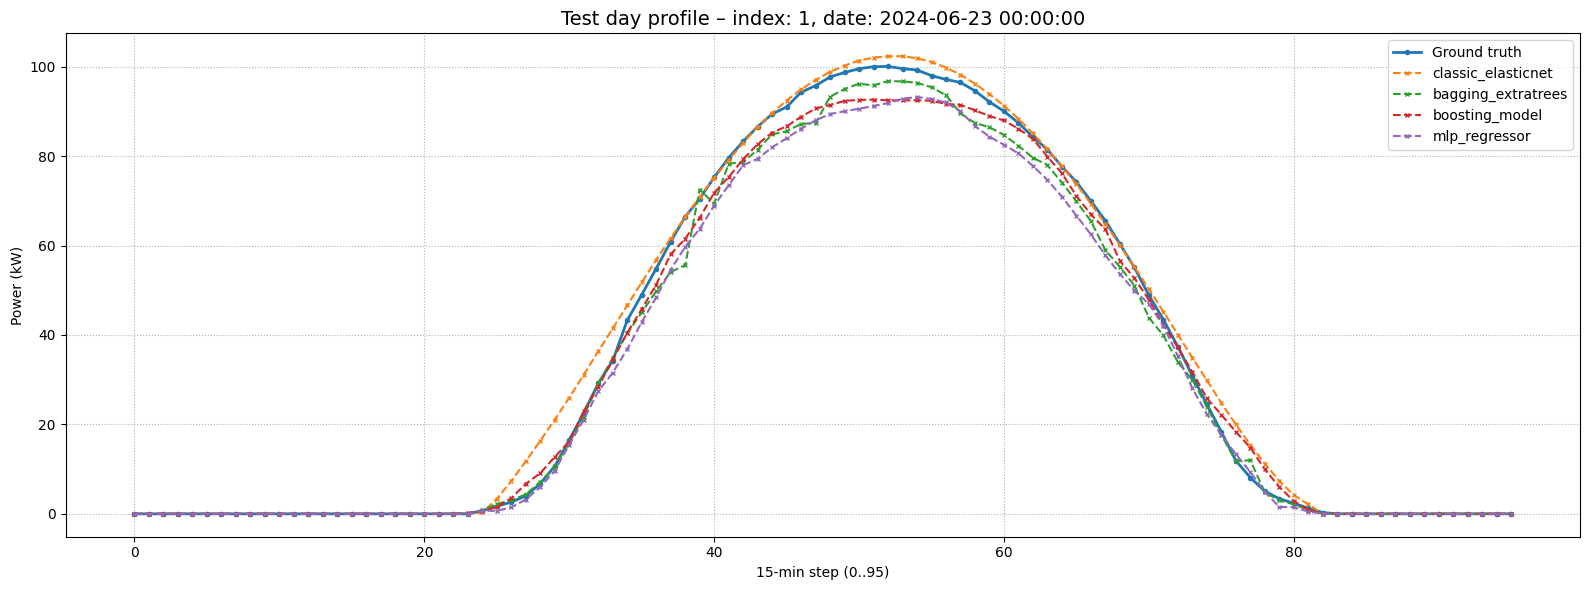


Training finished.
Now you can call, for example:
  pred_df = predict_future_day(forecast_df, model_name=BEST_MODEL_NAME)
or simply:
  pred_df = predict_future_day(forecast_df)   # auto uses artifacts/best_model.json if exists


In [2]:
# ============================================================
# CLASSIC ML REGRESSORS – DAY-AHEAD (96 → 96)  [FAIRNESS-SYMMETRIC REVISION]
#
# SAME DATA PIPELINE as deep pipeline:
#   (1) Load + Akima hourly->15min
#   (2) TZ alignment
#   (3) Day cleaning
#   (4) Meteo-only feature engineering (deploy-safe)
#   (5) Split by day (chronological)
#   (6) Day-level dataset (N,96,F) -> FLATTEN to (N*96,F) for classic ML
#   (7) Scaling (train-only)
#   (8) Train/Eval + metrics + plots
#   (9) predict_future_day() for deployment
#
# REVIZED FEATURE SELECTION (Two-stage):
#   Stage-1: Relevance prefilter (|corr(feature,target)|)
#   Stage-2: Cluster only the good candidates to remove redundancy
#   Final  : choose TOP_K_FEATS (if enough candidates)
#
# FAIRNESS (Matched to Deep Pipeline):
#   - Daylight-weighted training ENABLED via sample_weight (is_day mask):
#       w = 1 + (DAYLIGHT_WEIGHT-1) * is_day
#   - Test metrics computed AFTER deploy-like post-processing:
#       clip_negative + night_zero
#   - Optional daylight-only reporting via mask (is_day)
#
# NOTE:
#   - Some sklearn estimators (e.g., MLPRegressor) do NOT support sample_weight.
#     For those, we apply deterministic oversampling as an approximation.
# ============================================================

import os
import json
import random
import warnings
import inspect
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.interpolate import Akima1DInterpolator
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import ElasticNet
from sklearn.ensemble import ExtraTreesRegressor, HistGradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

import joblib

warnings.filterwarnings("ignore")
plt.style.use("default")

# ============================================================
# 0) GLOBAL SETTINGS
# ============================================================

GLOBAL_SEED = 42
np.random.seed(GLOBAL_SEED)
random.seed(GLOBAL_SEED)

# --- File paths ------------------------------------------------------
PWR_PATH    = r"C:\Users\Admin\Desktop\Vedat\ds_new2.xlsx"
MET_PATH    = r"C:\Users\Admin\Desktop\Vedat\open-meteo_v2.xlsx"
HOURLY_PATH = r"C:\Users\Admin\Desktop\Vedat\python_trials_new\hourly_data\hourly_data_v2.csv"

# Output directory
OUT_DIR = r"C:\Users\Admin\Desktop\Vedat\day_ahead_classic_ml_outputs"
os.makedirs(OUT_DIR, exist_ok=True)

MODEL_DIR = os.path.join(OUT_DIR, "models")
os.makedirs(MODEL_DIR, exist_ok=True)

ARTIFACT_DIR = os.path.join(OUT_DIR, "artifacts")
os.makedirs(ARTIFACT_DIR, exist_ok=True)

# --- Timezone and column settings -----------------------------------
TZ_LOCAL   = "Europe/Istanbul"
TARGET_TR  = "Toplam Aktif Güç(kW)"
TARGET_COL = "ActivePower_kW"

# GHI candidates
GHI_CANDIDATES = [
    "shortwave_radiation (W/m²)",
    "global_tilted_irradiance (W/m²)",
    "direct_radiation (W/m²)",
]

# --- Day-level cleaning flags ---------------------------------------
ENABLE_DAILY_GAP_CLEANING = False
DAILY_NA_THRESHOLD        = 0.20
MAX_INTERPOLATION_GAP     = 4
EXPECTED_STEPS_PER_DAY    = 96   # 24h * 4 (15-min)

# --- Train/Val/Test ratios (by day) ---------------------------------
TRAIN_RATIO = 0.80
VAL_RATIO   = 0.05

# ============================================================
# FEATURE SELECTION (Two-stage)
# ============================================================

TOP_K_FEATS = 5  # final selected feature count

# Stage-1 relevance filter
MIN_ABS_CORR_TO_TARGET = 0.2   # 0.02–0.10 can be tried; higher -> stricter

# Stage-1 candidate pool size
PRESELECT_TOP_N = 5 * TOP_K_FEATS  # typically 3xK–10xK works well

# Stage-2 distance thresholds (distance = 1 - |corr|)
FS_THRESHOLDS = np.unique(np.concatenate([
    np.arange(0.001, 0.021, 0.001),
    np.arange(0.02,  0.101, 0.005),
    np.arange(0.10,  0.51,  0.05),
]))

# ============================================================
# FAIRNESS: Daylight-weighted training (match deep pipeline)
# ============================================================

DAYLIGHT_WEIGHT = 3.0  # same meaning as deep pipeline
MASK_COL_FOR_DAYLIGHT = "is_day"

# ============================================================
# OPTIONAL: Daylight-only reporting (mask metrics; no weighted metrics)
# ============================================================

REPORT_DAYLIGHT_METRICS = True

# ============================================================
# DEPLOY-LIKE POSTPROCESS (match deep pipeline evaluation)
# ============================================================

CLIP_NEGATIVE = True
NIGHT_ZERO    = True

# ============================================================
# MODELS TO RUN
# ============================================================

MODELS_TO_RUN = [
    "classic_elasticnet",
    "bagging_extratrees",
    "boosting_model",
    "mlp_regressor",
]

# ============================================================
# BOOSTING GPU OPTION (CatBoost/XGBoost if available)
# ============================================================

BOOSTING_USE_GPU       = False
BOOSTING_GPU_DEVICES   = "0"

# ============================================================
# 1) DATA LOADING, AKIMA INTERPOLATION, TIMEZONE ALIGNMENT
# ============================================================

def akima_interpolate_series(time_old, values_old, time_new):
    values_old = np.asarray(values_old, dtype=float)
    mask = ~np.isnan(values_old)
    time_old_clean = np.asarray(time_old)[mask]
    values_old_clean = values_old[mask]

    x_old = time_old_clean.astype("datetime64[ns]").astype(np.int64)
    x_new = np.asarray(time_new).astype("datetime64[ns]").astype(np.int64)

    if len(x_old) < 3:
        return np.interp(x_new, x_old, values_old_clean)

    f = Akima1DInterpolator(x_old, values_old_clean)
    return f(x_new)


def load_and_build_master_df():
    # --- Power (15-min) ---
    df_pwr = pd.read_excel(PWR_PATH)
    df_pwr["Zaman"] = pd.to_datetime(df_pwr["Zaman"])
    df_pwr.set_index("Zaman", inplace=True)
    df_pwr.sort_index(inplace=True)

    if TARGET_TR in df_pwr.columns:
        df_pwr = df_pwr.rename(columns={TARGET_TR: TARGET_COL})
    elif TARGET_COL not in df_pwr.columns:
        raise KeyError(f"Power column not found: {TARGET_TR} or {TARGET_COL}")

    # --- Meteo (15-min) ---
    df_met = pd.read_excel(MET_PATH)
    df_met["time"] = pd.to_datetime(df_met["time"])
    df_met.set_index("time", inplace=True)
    df_met.sort_index(inplace=True)

    # --- Hourly meteo ---
    df_hourly = pd.read_csv(HOURLY_PATH)
    if "time" not in df_hourly.columns:
        raise KeyError("'time' column not found in hourly CSV.")
    df_hourly["time"] = pd.to_datetime(df_hourly["time"])
    df_hourly.set_index("time", inplace=True)
    df_hourly.sort_index(inplace=True)

    hourly_cols = [
        "pressure_msl",
        "surface_pressure",
        "cloud_cover",
        "cloud_cover_low",
        "cloud_cover_mid",
        "cloud_cover_high",
        "vapour_pressure_deficit",
    ]
    for c in hourly_cols:
        if c not in df_hourly.columns:
            print(f"[Warning] Hourly column missing: {c}")
    hourly_df = df_hourly[[c for c in hourly_cols if c in df_hourly.columns]].copy()

    # --- Hourly -> 15-min via Akima ---
    target_index = df_met.index.sort_values().unique()
    df_hourly_15 = pd.DataFrame(index=target_index)
    for col in hourly_df.columns:
        print(f"Akima interpolation hourly → 15-min for column: {col}")
        df_hourly_15[col] = akima_interpolate_series(
            hourly_df.index.values,
            hourly_df[col].values,
            target_index.values
        )

    # --- Timezone alignment ---
    df_met.index = df_met.index.tz_localize("UTC").tz_convert(TZ_LOCAL).tz_localize(None)
    df_hourly_15.index = df_hourly_15.index.tz_localize("UTC").tz_convert(TZ_LOCAL).tz_localize(None)
    df_pwr.index = df_pwr.index.tz_localize(TZ_LOCAL).tz_convert(TZ_LOCAL).tz_localize(None)

    # --- Join ---
    df = (
        df_met.join(df_hourly_15, how="inner")
              .join(df_pwr[[TARGET_COL]], how="inner")
              .sort_index()
    )

    # Optional drop
    first_day_to_drop = pd.to_datetime("2021-03-24").date()
    df = df[df.index.date != first_day_to_drop]

    # Determine GHI column
    ghi_col = None
    for c in GHI_CANDIDATES:
        if c in df.columns:
            ghi_col = c
            break
    if ghi_col is None:
        raise KeyError(f"No GHI-like column found among {GHI_CANDIDATES}")

    # Create 'is_day' if missing
    if "is_day" not in df.columns:
        df["is_day"] = (df[ghi_col] > 0).astype(int)

    # Add 'day' column
    df["day"] = df.index.normalize()

    print("Master DF shape:", df.shape)
    return df, ghi_col


# ============================================================
# 2) DAY-LEVEL CLEANING
# ============================================================

def clean_days_with_power_gaps(
    df,
    power_col=TARGET_COL,
    enable_gap_cleaning=ENABLE_DAILY_GAP_CLEANING,
    daily_na_threshold=DAILY_NA_THRESHOLD,
    max_interp_gap=MAX_INTERPOLATION_GAP,
    expected_steps_per_day=EXPECTED_STEPS_PER_DAY,
):
    keep_groups = []
    removed_days = []

    for day, g in df.groupby("day"):
        g = g.sort_index().copy()
        y = g[power_col].astype(float)

        if len(g) != expected_steps_per_day:
            removed_days.append((day, "wrong_length", len(g)))
            continue

        zero_ratio = (y == 0).mean()
        if zero_ratio > 0.80:
            removed_days.append((day, "too_many_zeros", float(zero_ratio)))
            continue

        na_ratio = y.isna().mean()
        if not enable_gap_cleaning:
            if na_ratio > 0.0:
                removed_days.append((day, "has_nan_no_cleaning", float(na_ratio)))
                continue
        else:
            if na_ratio > daily_na_threshold:
                removed_days.append((day, "na_ratio_too_high", float(na_ratio)))
                continue

            y_interp = y.interpolate(limit=max_interp_gap, limit_direction="both")
            if y_interp.isna().any():
                removed_days.append((day, "nan_after_interp", float(y_interp.isna().mean())))
                continue
            g[power_col] = y_interp

        keep_groups.append(g)

    if not keep_groups:
        raise RuntimeError("No valid days left after cleaning. Check thresholds.")

    df_clean = pd.concat(keep_groups).sort_index()
    print(f"Remaining days after cleaning: {df_clean['day'].nunique()}")
    print(f"Removed days: {len(removed_days)}")
    return df_clean, removed_days


# ============================================================
# 2b) FEATURE ENGINEERING (METEO-ONLY; DEPLOY-SAFE)
# ============================================================

def add_feature_engineering_meteo_only(df, ghi_col):
    df = df.copy()
    idx = df.index

    if "day" not in df.columns:
        df["day"] = idx.normalize()

    if "is_day" not in df.columns:
        if ghi_col not in df.columns:
            found = None
            for c in GHI_CANDIDATES:
                if c in df.columns:
                    found = c
                    break
            if found is None:
                raise KeyError(f"Cannot build is_day: no ghi column found among {GHI_CANDIDATES}")
            ghi_col = found
        df["is_day"] = (df[ghi_col] > 0).astype(int)

    doy = idx.dayofyear
    df["doy_sin"] = np.sin(2 * np.pi * (doy / 365.0))
    df["doy_cos"] = np.cos(2 * np.pi * (doy / 365.0))

    minute_of_day = idx.hour * 60 + idx.minute
    df["tod_sin"] = np.sin(2 * np.pi * (minute_of_day / 1440.0))
    df["tod_cos"] = np.cos(2 * np.pi * (minute_of_day / 1440.0))

    minutes = (idx - idx.normalize()) / pd.Timedelta(minutes=15)
    df["slot"] = minutes.astype(int)

    if ghi_col not in df.columns:
        raise KeyError(f"ghi_col='{ghi_col}' not found in df for cs_index feature.")
    ghi = df[ghi_col].astype(float)
    daily_max_ghi = df.groupby("day")[ghi_col].transform("max").replace(0, np.nan)
    cs_index = (ghi / daily_max_ghi).replace([np.inf, -np.inf], np.nan)
    df["cs_index_dailymax"] = cs_index.clip(0, 5).fillna(0.0)

    return df


# ============================================================
# 2c) FEATURE SELECTION (Two-stage: Relevance -> Clustering)
# ============================================================

def compute_abs_target_corr(df, target_col, feature_cols) -> pd.Series:
    y = df[target_col].astype(float)
    scores = {}

    for c in feature_cols:
        x = df[c]
        if not np.issubdtype(x.dtype, np.number):
            continue
        x = pd.to_numeric(x, errors="coerce")
        corr = x.corr(y)
        if pd.isna(corr):
            continue
        scores[c] = float(abs(corr))

    if not scores:
        return pd.Series(dtype=float)

    return pd.Series(scores).sort_values(ascending=False)


def preselect_candidate_features(df, target_col, feature_cols,
                                 top_n=PRESELECT_TOP_N,
                                 min_abs_corr=MIN_ABS_CORR_TO_TARGET):
    s = compute_abs_target_corr(df, target_col, feature_cols)

    if len(s) == 0:
        return [], s

    if min_abs_corr is not None:
        s = s[s >= float(min_abs_corr)]

    if top_n is not None and len(s) > int(top_n):
        s = s.head(int(top_n))

    return s.index.tolist(), s


def build_distance_and_linkage(df, feature_cols):
    corr = df[feature_cols].corr().abs().fillna(0.0)
    distance = 1.0 - corr
    np.fill_diagonal(distance.values, 0.0)

    Z = linkage(squareform(distance.values), method="average")
    return distance, Z


def clusters_from_linkage(Z, threshold):
    return fcluster(Z, t=float(threshold), criterion="distance")


def select_reps_from_clusters(feature_cols, cluster_ids, target_corr_abs: pd.Series):
    cluster_table = pd.DataFrame({"feature": feature_cols, "cluster_id": cluster_ids})
    reps = []
    for cid in sorted(cluster_table["cluster_id"].unique()):
        members = cluster_table.loc[cluster_table["cluster_id"] == cid, "feature"].tolist()
        best_f = max(members, key=lambda f: float(target_corr_abs.get(f, 0.0)))
        reps.append(best_f)
    return reps, cluster_table


def auto_threshold_for_k(Z, thresholds, target_k, candidate_n):
    rows = []

    if candidate_n <= target_k:
        table = pd.DataFrame([{
            "threshold": None, "corr_limit": None, "n_clusters": int(candidate_n),
            "note": f"candidate_n({candidate_n}) <= target_k({target_k})"
        }])
        return None, table

    for th in thresholds:
        cl = clusters_from_linkage(Z, th)
        rows.append({
            "threshold": float(round(th, 6)),
            "corr_limit": float(round(1.0 - th, 6)),
            "n_clusters": int(len(np.unique(cl)))
        })
    table = pd.DataFrame(rows)

    feasible = table[table["n_clusters"] >= int(target_k)].copy()
    if len(feasible) == 0:
        best_row = table.sort_values(["n_clusters", "threshold"], ascending=[False, True]).iloc[0]
    else:
        feasible["err"] = feasible["n_clusters"] - int(target_k)
        best_row = feasible.sort_values(["err", "threshold"], ascending=[True, False]).iloc[0]

    return float(best_row["threshold"]), table


def two_stage_feature_selection(df_train, target_col, feature_cols_all,
                                top_k=TOP_K_FEATS,
                                preselect_top_n=PRESELECT_TOP_N,
                                min_abs_corr=MIN_ABS_CORR_TO_TARGET,
                                thresholds=FS_THRESHOLDS):
    # Stage-1: relevance
    candidates, rel_scores = preselect_candidate_features(
        df=df_train, target_col=target_col, feature_cols=feature_cols_all,
        top_n=preselect_top_n, min_abs_corr=min_abs_corr
    )

    if len(candidates) == 0:
        # fallback: disable min_abs_corr, use only top_n
        candidates, rel_scores = preselect_candidate_features(
            df=df_train, target_col=target_col, feature_cols=feature_cols_all,
            top_n=preselect_top_n, min_abs_corr=None
        )

    if len(candidates) == 0:
        raise RuntimeError("Feature selection failed: no numeric candidate features found with valid correlation.")

    # If already <= K
    if len(candidates) <= int(top_k):
        return candidates, {
            "candidates": candidates,
            "rel_scores": rel_scores,
            "best_threshold": None,
            "threshold_table": pd.DataFrame(),
            "cluster_table": pd.DataFrame()
        }

    # Stage-2: clustering (candidates only)
    target_corr_abs = compute_abs_target_corr(df_train, target_col, candidates).reindex(candidates).fillna(0.0)
    distance, Z = build_distance_and_linkage(df_train, candidates)
    best_th, th_table = auto_threshold_for_k(Z, thresholds, int(top_k), len(candidates))

    cluster_ids = clusters_from_linkage(Z, best_th)
    reps, cluster_table = select_reps_from_clusters(candidates, cluster_ids, target_corr_abs)

    reps_sorted = sorted(reps, key=lambda f: float(target_corr_abs.get(f, 0.0)), reverse=True)
    final_feats = reps_sorted[:int(top_k)]

    # Safety: if still <K, fill from relevance
    if len(final_feats) < int(top_k):
        all_sorted = list(rel_scores.index)
        for f in all_sorted:
            if f not in final_feats:
                final_feats.append(f)
            if len(final_feats) == int(top_k):
                break

    return final_feats, {
        "candidates": candidates,
        "rel_scores": rel_scores,
        "best_threshold": best_th,
        "threshold_table": th_table,
        "cluster_table": cluster_table
    }


# ============================================================
# 3) TRAIN/VAL/TEST SPLIT BY DAY
# ============================================================

def split_days_train_val_test(df, train_ratio=TRAIN_RATIO, val_ratio=VAL_RATIO):
    unique_days = np.array(sorted(df["day"].unique()))
    n_days = len(unique_days)

    n_train = max(1, int(n_days * train_ratio))
    n_val   = max(1, int(n_days * val_ratio))

    days_train = unique_days[:n_train]
    days_val   = unique_days[n_train:n_train + n_val]
    days_test  = unique_days[n_train + n_val:]

    test_ratio = 1.0 - (train_ratio + val_ratio)

    print(f"Total days: {n_days}")
    print(f"Ratios -> Train: {train_ratio:.2f}, Val: {val_ratio:.2f}, Test: {test_ratio:.2f}")
    print(f"Split  -> Train days: {len(days_train)}, Val days: {len(days_val)}, Test days: {len(days_test)}")
    return days_train, days_val, days_test


# ============================================================
# 4) DAY-LEVEL DATASET CREATION + mask
# ============================================================

def create_day_level_dataset(
    df,
    feature_cols,
    target_col=TARGET_COL,
    expected_steps=EXPECTED_STEPS_PER_DAY,
    mask_col=MASK_COL_FOR_DAYLIGHT
):
    X_list, y_list, day_list, m_list = [], [], [], []

    for day, g in df.groupby("day"):
        g = g.sort_index()

        if len(g) != expected_steps:
            continue

        needed_cols = list(feature_cols) + [target_col]
        if g[needed_cols].isna().any().any():
            continue

        X = g[feature_cols].values.astype(np.float32)   # (96, F)
        y = g[[target_col]].values.astype(np.float32)   # (96, 1)

        if mask_col in g.columns:
            m = g[mask_col].fillna(0).values.astype(np.float32).reshape(-1)  # (96,)
        else:
            m = np.ones((expected_steps,), dtype=np.float32)

        if len(m) != expected_steps:
            continue

        X_list.append(X)
        y_list.append(y)
        day_list.append(day)
        m_list.append(m)

    if not X_list:
        return None, None, None, None

    return (
        np.stack(X_list, axis=0),
        np.stack(y_list, axis=0),
        np.array(day_list),
        np.stack(m_list, axis=0),
    )


def flatten_day_level(X_day, y_day, m_day=None):
    n, t, f = X_day.shape
    X_flat = X_day.reshape(n * t, f)
    y_flat = y_day.reshape(n * t, 1)
    m_flat = None
    if m_day is not None:
        m_flat = m_day.reshape(n * t)
    return X_flat, y_flat, m_flat


def make_daylight_sample_weight(mask_flat, daylight_weight=DAYLIGHT_WEIGHT):
    """
    mask_flat: 1D array (n_samples,), values in {0,1} (is_day)
    return: w = 1 + (daylight_weight-1)*mask
    """
    if mask_flat is None:
        return None
    m = np.asarray(mask_flat).astype(np.float32)
    w = 1.0 + (float(daylight_weight) - 1.0) * m
    return w.astype(np.float32)


# ============================================================
# 5) METRICS + POSTPROCESS + (OPTIONAL) MASKED METRICS
# ============================================================

def postprocess_predictions(y_pred_orig, mask_day=None, clip_negative=True, night_zero=True):
    """
    y_pred_orig: (N,96,1) or (N,96)
    mask_day  : (N,96) is_day mask (0/1)
    """
    y = np.array(y_pred_orig, copy=True)
    squeezed = False
    if y.ndim == 3 and y.shape[-1] == 1:
        y = y.squeeze(-1)
        squeezed = True

    if clip_negative:
        y = np.maximum(y, 0.0)

    if night_zero and mask_day is not None:
        night_mask = (np.asarray(mask_day).astype(int) == 0)
        y[night_mask] = 0.0

    if squeezed:
        y = y[..., np.newaxis]
    return y


def compute_overall_metrics(y_true, y_pred):
    y_true_flat = np.asarray(y_true).reshape(-1)
    y_pred_flat = np.asarray(y_pred).reshape(-1)

    mse  = mean_squared_error(y_true_flat, y_pred_flat)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_true_flat, y_pred_flat)
    r2   = r2_score(y_true_flat, y_pred_flat)

    return {"MSE": float(mse), "RMSE": float(rmse), "MAE": float(mae), "R2": float(r2)}


def compute_daily_metrics(day_array, Y_true, Y_pred):
    records = []
    unique_days = np.unique(day_array)
    for d in unique_days:
        idx = np.where(day_array == d)[0]
        y_t = np.asarray(Y_true)[idx].reshape(-1)
        y_p = np.asarray(Y_pred)[idx].reshape(-1)

        mse_d  = mean_squared_error(y_t, y_p)
        rmse_d = np.sqrt(mse_d)
        mae_d  = mean_absolute_error(y_t, y_p)
        r2_d   = r2_score(y_t, y_p)

        records.append({"day": d, "MSE": float(mse_d), "RMSE": float(rmse_d), "MAE": float(mae_d), "R2": float(r2_d)})

    return pd.DataFrame(records).set_index("day")


def compute_overall_metrics_masked(y_true, y_pred, mask_day):
    yt = np.asarray(y_true)
    yp = np.asarray(y_pred)
    m  = np.asarray(mask_day)

    if yt.ndim == 3:
        yt = yt.squeeze(-1)
    if yp.ndim == 3:
        yp = yp.squeeze(-1)

    m_bool = (m.astype(np.int32) > 0)
    if m_bool.sum() == 0:
        return {"MSE": np.nan, "RMSE": np.nan, "MAE": np.nan, "R2": np.nan, "n_points": 0}

    yt_sel = yt[m_bool]
    yp_sel = yp[m_bool]

    mse  = mean_squared_error(yt_sel, yp_sel)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(yt_sel, yp_sel)
    try:
        r2 = r2_score(yt_sel, yp_sel)
    except Exception:
        r2 = np.nan

    return {"MSE": float(mse), "RMSE": float(rmse), "MAE": float(mae), "R2": float(r2), "n_points": int(m_bool.sum())}


def plot_test_day(day_no, d_test, Y_test_orig, preds_by_model, model_list=None):
    if d_test is None or len(d_test) == 0:
        print("Empty test set, nothing to plot.")
        return
    if model_list is None:
        model_list = list(preds_by_model.keys())

    unique_days = np.unique(d_test)
    if day_no < 1 or day_no > len(unique_days):
        print(f"Invalid day_no={day_no}. There are {len(unique_days)} unique test days.")
        return

    day_label = unique_days[day_no - 1]
    idxs = np.where(d_test == day_label)[0]
    if len(idxs) == 0:
        print(f"No sample found for day {day_label}.")
        return

    y_true = np.asarray(Y_test_orig)[idxs].reshape(-1)

    plt.figure(figsize=(16, 6))
    plt.plot(y_true, label="Ground truth", marker="o", ms=3, linewidth=2)

    for model_name in model_list:
        if model_name not in preds_by_model:
            continue
        y_pred_day = np.asarray(preds_by_model[model_name])[idxs].reshape(-1)
        plt.plot(y_pred_day, label=f"{model_name}", linestyle="--", marker="x", ms=3)

    plt.title(f"Test day profile – index: {day_no}, date: {day_label}", fontsize=14)
    plt.xlabel("15-min step (0..95)")
    plt.ylabel("Power (kW)")
    plt.grid(True, linestyle=":")
    plt.legend()
    plt.tight_layout()
    plt.show()


# ============================================================
# 6) BOOSTING BACKENDS (CatBoost -> XGBoost -> HistGB fallback)
# ============================================================

def try_build_catboost_regressor(seed=GLOBAL_SEED):
    try:
        from catboost import CatBoostRegressor

        params = dict(
            iterations=12000,
            learning_rate=0.03,
            depth=10,
            loss_function="RMSE",
            eval_metric="RMSE",
            l2_leaf_reg=3.0,
            random_seed=seed,
            subsample=0.8,
            rsm=0.8,
            bootstrap_type="Bernoulli",
            od_type="Iter",
            od_wait=300,
            use_best_model=True,
            verbose=False,
            allow_writing_files=False
        )

        if BOOSTING_USE_GPU:
            params.update({"task_type": "GPU", "devices": BOOSTING_GPU_DEVICES})
        else:
            params.update({"task_type": "CPU", "thread_count": -1})

        return CatBoostRegressor(**params), "catboost"
    except Exception:
        return None, None


def try_build_xgb_regressor(seed=GLOBAL_SEED):
    try:
        from xgboost import XGBRegressor

        tree_method = "gpu_hist" if BOOSTING_USE_GPU else "hist"

        model = XGBRegressor(
            n_estimators=20000,
            learning_rate=0.01,
            max_depth=10,
            min_child_weight=1,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_alpha=0.0,
            reg_lambda=1.0,
            gamma=0.0,
            objective="reg:squarederror",
            tree_method=tree_method,
            random_state=seed,
            n_jobs=-1,
        )
        return model, "xgboost"
    except Exception:
        return None, None


def build_boosting_model(seed=GLOBAL_SEED):
    cb, backend = try_build_catboost_regressor(seed=seed)
    if cb is not None:
        return cb, backend

    xgb, backend = try_build_xgb_regressor(seed=seed)
    if xgb is not None:
        return xgb, backend

    hgb = HistGradientBoostingRegressor(
        loss="squared_error",
        learning_rate=0.03,
        max_depth=10,
        max_leaf_nodes=127,
        min_samples_leaf=20,
        l2_regularization=0.0,
        max_bins=255,
        early_stopping=False,   # external VAL exists; keep deterministic
        random_state=seed,
    )
    return hgb, "sklearn_histgb"


def _safe_predict_boosting(model, backend, X):
    if backend == "xgboost":
        try:
            if hasattr(model, "best_iteration") and model.best_iteration is not None:
                return model.predict(X, iteration_range=(0, int(model.best_iteration) + 1))
        except Exception:
            pass
    return model.predict(X)


# ============================================================
# 7) MODEL BUILDERS (COMPLEXITY-UPGRADED)
# ============================================================

def build_extratrees_bagging(seed=GLOBAL_SEED):
    return ExtraTreesRegressor(
        n_estimators=1500,
        max_depth=None,
        min_samples_leaf=1,
        min_samples_split=2,
        max_features=1.0,
        bootstrap=True,
        n_jobs=-1,
        random_state=seed,
    )


def build_mlp_regressor(seed=GLOBAL_SEED):
    # NOTE: sklearn MLPRegressor does NOT support sample_weight.
    # We'll approximate weighting via oversampling in the train loop.
    return MLPRegressor(
        hidden_layer_sizes=(512, 256, 128),
        activation="relu",
        solver="adam",
        alpha=5e-5,
        batch_size=4096,
        learning_rate="adaptive",
        learning_rate_init=5e-4,
        max_iter=1500,
        early_stopping=True,
        validation_fraction=0.10,
        n_iter_no_change=40,
        random_state=seed,
        verbose=False
    )


# ============================================================
# 8) TRAIN/EVAL LOOP (classic regressors) + DAYLIGHT WEIGHTS
# ============================================================

def _supports_sample_weight(estimator) -> bool:
    try:
        sig = inspect.signature(estimator.fit)
        return ("sample_weight" in sig.parameters)
    except Exception:
        return False


def _weighted_rmse(y_true, y_pred, sample_weight=None) -> float:
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    err2 = (y_true - y_pred) ** 2
    if sample_weight is None:
        return float(np.sqrt(np.mean(err2)))
    w = np.asarray(sample_weight).reshape(-1).astype(np.float64)
    return float(np.sqrt(np.average(err2, weights=w)))


def _oversample_by_weight(X, y, sample_weight, max_repeat=10):
    """
    Deterministic oversampling for estimators without sample_weight.
    For daylight_weight=3, typically repeats are 1 (night) or 3 (day).
    """
    if sample_weight is None:
        return X, y

    w = np.asarray(sample_weight).reshape(-1)
    reps = np.clip(np.rint(w).astype(int), 1, int(max_repeat))
    X_rep = np.repeat(X, reps, axis=0)
    y_rep = np.repeat(y, reps, axis=0)
    return X_rep, y_rep


def tune_elasticnet_on_val(
    X_tr, y_tr, sw_tr,
    X_va, y_va, sw_va,
    alphas=None, l1_ratios=None,
    verbose=True
):
    """
    Chronology-safe tuning on external VAL, using daylight-weighted objective.
    y_* are 1D arrays (scaled). sw_* are 1D arrays (same length).
    """
    if alphas is None:
        alphas = [1e-6, 3e-6, 1e-5, 3e-5, 1e-4, 3e-4, 1e-3, 3e-3, 1e-2]
    if l1_ratios is None:
        l1_ratios = [0.0, 0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9]

    best = {"rmse": np.inf, "alpha": None, "l1_ratio": None, "model": None, "used_sample_weight": False}

    for a in alphas:
        for l1 in l1_ratios:
            m = ElasticNet(
                alpha=float(a),
                l1_ratio=float(l1),
                max_iter=30000,
                fit_intercept=True,
                selection="cyclic",
                random_state=GLOBAL_SEED
            )

            used_w = False
            try:
                if sw_tr is not None and _supports_sample_weight(m):
                    m.fit(X_tr, y_tr, sample_weight=sw_tr)
                    used_w = True
                else:
                    m.fit(X_tr, y_tr)
            except TypeError:
                m.fit(X_tr, y_tr)

            p = m.predict(X_va)
            rmse = _weighted_rmse(y_va, p, sample_weight=sw_va)

            if rmse < best["rmse"]:
                best.update({"rmse": rmse, "alpha": float(a), "l1_ratio": float(l1), "model": m, "used_sample_weight": used_w})

    if verbose:
        print(f"[ElasticNet tuning] best_wRMSE(scaled)={best['rmse']:.6f} | alpha={best['alpha']} | l1_ratio={best['l1_ratio']} | used_sample_weight={best['used_sample_weight']}")
    return best["model"], {"alpha": best["alpha"], "l1_ratio": best["l1_ratio"], "wRMSE_scaled": best["rmse"], "used_sample_weight": best["used_sample_weight"]}


def train_and_evaluate_regressor(
    model_name,
    estimator,
    X_train, y_train_scaled, sw_train,
    X_val,   y_val_scaled,   sw_val,
    X_test,
    y_test_orig_day,
    d_test,
    scY,
    expected_steps=EXPECTED_STEPS_PER_DAY,
    m_test_day=None,                  # is_day mask (N,96)
    boosting_backend=None
):
    """
    X_* are flattened (n_samples, F)
    y_*_scaled are 1D arrays (n_samples,)
    sw_* are 1D arrays (n_samples,)
    """
    print("\n======================================")
    print(f"Training classic model: {model_name}")
    print("======================================")

    # --- FIT ---
    if model_name == "classic_elasticnet":
        estimator, tune_info = tune_elasticnet_on_val(
            X_train, y_train_scaled, sw_train,
            X_val,   y_val_scaled,   sw_val
        )
        print(f"[ElasticNet] tuned params: {tune_info}")

    elif boosting_backend in ("catboost", "xgboost"):
        if boosting_backend == "catboost":
            # Use Pool to pass weights for train and eval
            try:
                from catboost import Pool
                train_pool = Pool(X_train, y_train_scaled, weight=sw_train)
                val_pool   = Pool(X_val,   y_val_scaled,   weight=sw_val)
                estimator.fit(train_pool, eval_set=val_pool)
            except Exception as e:
                print(f"[Warning] CatBoost weighted Pool fit failed ({e}); fallback to unweighted fit.")
                estimator.fit(X_train, y_train_scaled, eval_set=(X_val, y_val_scaled))

        else:
            # XGBoost: pass sample_weight + sample_weight_eval_set if available
            try:
                estimator.fit(
                    X_train, y_train_scaled,
                    sample_weight=sw_train,
                    eval_set=[(X_val, y_val_scaled)],
                    sample_weight_eval_set=[sw_val],
                    eval_metric="rmse",
                    verbose=False,
                    early_stopping_rounds=500
                )
            except TypeError:
                # older xgboost versions may not accept sample_weight_eval_set
                try:
                    estimator.fit(
                        X_train, y_train_scaled,
                        sample_weight=sw_train,
                        eval_set=[(X_val, y_val_scaled)],
                        eval_metric="rmse",
                        verbose=False,
                        early_stopping_rounds=500
                    )
                except Exception as e:
                    print(f"[Warning] XGBoost weighted fit failed ({e}); fallback to unweighted fit.")
                    estimator.fit(
                        X_train, y_train_scaled,
                        eval_set=[(X_val, y_val_scaled)],
                        eval_metric="rmse",
                        verbose=False,
                        early_stopping_rounds=500
                    )

    else:
        # sklearn estimators
        used_w = False
        if sw_train is not None and _supports_sample_weight(estimator):
            try:
                estimator.fit(X_train, y_train_scaled, sample_weight=sw_train)
                used_w = True
            except TypeError:
                used_w = False
                estimator.fit(X_train, y_train_scaled)
        else:
            # Estimator does not support sample_weight -> oversample as approximation (e.g., MLPRegressor)
            if sw_train is not None and not _supports_sample_weight(estimator):
                X_os, y_os = _oversample_by_weight(X_train, y_train_scaled, sw_train, max_repeat=int(np.ceil(DAYLIGHT_WEIGHT)))
                print(f"[Info] {model_name}: sample_weight not supported -> oversampling applied. Train size: {len(y_train_scaled)} -> {len(y_os)}")
                estimator.fit(X_os, y_os)
            else:
                estimator.fit(X_train, y_train_scaled)

        if sw_train is not None:
            print(f"[Info] {model_name}: used_sample_weight={used_w} (if False and model has no weights, oversampling may have been used).")

    # --- PREDICT (scaled) ---
    if boosting_backend is not None:
        y_pred_scaled_flat = _safe_predict_boosting(estimator, boosting_backend, X_test)
    else:
        y_pred_scaled_flat = estimator.predict(X_test)

    y_pred_scaled_flat = np.asarray(y_pred_scaled_flat).reshape(-1, 1)

    # --- INVERSE TRANSFORM to original scale ---
    y_pred_orig_flat = scY.inverse_transform(y_pred_scaled_flat).reshape(-1)

    # reshape back to (N_days,96,1)
    n_test_days = y_test_orig_day.shape[0]
    y_pred_orig_day = y_pred_orig_flat.reshape(n_test_days, expected_steps, 1)

    # --- POST-PROCESS (deploy-like) ---
    y_pred_post_day = postprocess_predictions(
        y_pred_orig_day,
        mask_day=m_test_day,
        clip_negative=CLIP_NEGATIVE,
        night_zero=NIGHT_ZERO
    )

    # --- METRICS (POST-PROCESSED, ALL timesteps) ---
    overall_all = compute_overall_metrics(y_test_orig_day, y_pred_post_day)
    daily_all   = compute_daily_metrics(d_test, y_test_orig_day, y_pred_post_day)

    print(f"\n{model_name} TEST metrics (ORIGINAL scale, POST-PROCESSED):")
    print(f"  [ALL ] RMSE={overall_all['RMSE']:.2f} | MAE={overall_all['MAE']:.2f} | R²={overall_all['R2']:.3f}")

    # --- DAYLIGHT metrics (optional) ---
    overall_day = None
    daily_day = None
    if REPORT_DAYLIGHT_METRICS and (m_test_day is not None):
        overall_day = compute_overall_metrics_masked(y_test_orig_day, y_pred_post_day, m_test_day)
        print(f"  [DAY ] RMSE={overall_day['RMSE']:.2f} | MAE={overall_day['MAE']:.2f} | R²={overall_day['R2']:.3f} | n={overall_day['n_points']}")

    # --- SAVE MODEL ---
    model_path = os.path.join(MODEL_DIR, f"{model_name}.joblib")
    try:
        joblib.dump(estimator, model_path)
        print(f"[Saved] {model_name} -> {model_path}")
    except Exception as e:
        print(f"[Warning] joblib.dump failed for {model_name}: {e}")

    return estimator, y_pred_post_day, overall_all, overall_day, daily_all, daily_day


# ============================================================
# 9) PREDICT FUTURE DAY (CALL AFTER TRAINING)
# ============================================================

def _resolve_artifacts_for_prediction(model_name,
                                      model=None,
                                      selected_features=None,
                                      scX=None,
                                      scY=None,
                                      ghi_col=None):
    if selected_features is None:
        selected_features = globals().get("selected_features", None)
    if selected_features is None:
        f_path = os.path.join(ARTIFACT_DIR, "selected_features.json")
        if os.path.exists(f_path):
            with open(f_path, "r", encoding="utf-8") as f:
                selected_features = json.load(f)

    if ghi_col is None:
        ghi_col = globals().get("ghi_col", None)
    if ghi_col is None:
        meta_path = os.path.join(ARTIFACT_DIR, "meta.json")
        if os.path.exists(meta_path):
            with open(meta_path, "r", encoding="utf-8") as f:
                meta = json.load(f)
            ghi_col = meta.get("ghi_col")

    if scX is None:
        scX = globals().get("scX", None)
    if scX is None:
        sx = os.path.join(ARTIFACT_DIR, "scaler_X.joblib")
        if os.path.exists(sx):
            scX = joblib.load(sx)

    if scY is None:
        scY = globals().get("scY", None)
    if scY is None:
        sy = os.path.join(ARTIFACT_DIR, "scaler_Y.joblib")
        if os.path.exists(sy):
            scY = joblib.load(sy)

    if model is None:
        mt = globals().get("models_trained", {})
        if isinstance(mt, dict) and model_name in mt:
            model = mt[model_name]

    if model is None:
        mp = os.path.join(MODEL_DIR, f"{model_name}.joblib")
        if os.path.exists(mp):
            model = joblib.load(mp)

    if model is None:
        raise ValueError(
            f"Model could not be resolved. Provide model=... or ensure model file exists under {MODEL_DIR}. "
            f"Missing: {model_name}.joblib"
        )

    if selected_features is None or scX is None or scY is None or ghi_col is None:
        raise ValueError("Artifacts missing for prediction. Need selected_features, scX, scY, ghi_col.")

    return model, selected_features, scX, scY, ghi_col


def predict_future_day(
    forecast_df: pd.DataFrame,
    model_name: str = None,
    model=None,
    selected_features=None,
    scX=None,
    scY=None,
    ghi_col=None,
    input_timezone: str = "UTC",
    tz_local: str = TZ_LOCAL,
    expected_steps: int = EXPECTED_STEPS_PER_DAY,
    clip_negative: bool = True,
    night_zero: bool = True,
    capacity_kw: float = None
) -> pd.DataFrame:

    if model_name is None:
        best_path = os.path.join(ARTIFACT_DIR, "best_model.json")
        if os.path.exists(best_path):
            with open(best_path, "r", encoding="utf-8") as f:
                best = json.load(f)
            model_name = best.get("best_model_name")
        if not model_name:
            model_name = "boosting_model"

    model, selected_features, scX, scY, ghi_col = _resolve_artifacts_for_prediction(
        model_name=model_name,
        model=model,
        selected_features=selected_features,
        scX=scX,
        scY=scY,
        ghi_col=ghi_col
    )

    df = forecast_df.copy()

    if not isinstance(df.index, pd.DatetimeIndex):
        if "time" in df.columns:
            df["time"] = pd.to_datetime(df["time"])
            df = df.set_index("time")
        else:
            raise ValueError("forecast_df must have a DatetimeIndex or a 'time' column.")

    df.index = pd.to_datetime(df.index)
    df = df.sort_index()

    if df.index.tz is None:
        df.index = df.index.tz_localize(input_timezone).tz_convert(tz_local).tz_localize(None)
    else:
        df.index = df.index.tz_convert(tz_local).tz_localize(None)

    if len(df) != expected_steps:
        raise ValueError(f"forecast_df must have exactly {expected_steps} rows. Got {len(df)} rows.")

    if ghi_col not in df.columns:
        found = None
        for c in GHI_CANDIDATES:
            if c in df.columns:
                found = c
                break
        if found is None:
            raise KeyError(f"Forecast DF is missing ghi_col='{ghi_col}' and none of {GHI_CANDIDATES} exist.")
        ghi_col = found

    df_feat = add_feature_engineering_meteo_only(df, ghi_col)

    missing = [c for c in selected_features if c not in df_feat.columns]
    if missing:
        raise KeyError(f"Forecast DF missing required feature columns: {missing}")

    X = df_feat[selected_features].values.astype(np.float32)   # (96,F)
    Xs = scX.transform(X)                                      # (96,F)

    y_scaled = model.predict(Xs)
    y_scaled = np.asarray(y_scaled).reshape(-1, 1)
    y = scY.inverse_transform(y_scaled).reshape(-1)            # (96,)

    if clip_negative:
        y = np.maximum(y, 0.0)

    if night_zero and "is_day" in df_feat.columns:
        night_mask = (df_feat["is_day"].values.astype(int) == 0)
        y[night_mask] = 0.0

    if capacity_kw is not None:
        y = np.clip(y, 0.0, float(capacity_kw))

    return pd.DataFrame({"pred_active_power_kW": y}, index=df_feat.index)


# ============================================================
# 10) MAIN
# ============================================================

if __name__ == "__main__":
    RUN_ID = datetime.now().strftime("%Y%m%d_%H%M%S")

    print("\n[MODELS_TO_RUN]")
    for m in MODELS_TO_RUN:
        print(f" - {m}")

    # 1) Load
    df_master, ghi_col = load_and_build_master_df()

    # 2) Clean
    df_clean, removed_days = clean_days_with_power_gaps(df_master)

    # 3) Feature engineering
    df_feat = add_feature_engineering_meteo_only(df_clean, ghi_col)

    # 4) Split
    days_train, days_val, days_test = split_days_train_val_test(df_feat)

    df_train = df_feat[df_feat["day"].isin(days_train)].copy()
    df_val   = df_feat[df_feat["day"].isin(days_val)].copy()
    df_test  = df_feat[df_feat["day"].isin(days_test)].copy()

    print("Train shape:", df_train.shape)
    print("Val   shape:", df_val.shape)
    print("Test  shape:", df_test.shape)

    # 5) Feature selection (Two-stage, train-only)
    exclude_cols = [TARGET_COL, "day"]
    numeric_cols = [c for c in df_feat.columns if np.issubdtype(df_feat[c].dtype, np.number)]
    feature_cols_all = [c for c in numeric_cols if c not in exclude_cols]

    print("\n===== FEATURE SELECTION (Two-stage: Relevance -> Clustering) =====")
    selected_features, fs_debug = two_stage_feature_selection(
        df_train=df_train,
        target_col=TARGET_COL,
        feature_cols_all=feature_cols_all,
        top_k=TOP_K_FEATS,
        preselect_top_n=PRESELECT_TOP_N,
        min_abs_corr=MIN_ABS_CORR_TO_TARGET,
        thresholds=FS_THRESHOLDS
    )

    print(f"TOP_K_FEATS={TOP_K_FEATS} | selected={len(selected_features)}")
    print("Selected features:")
    print(selected_features)

    # FS debug save (optional)
    try:
        fs_debug["rel_scores"].to_csv(os.path.join(ARTIFACT_DIR, "fs_stage1_relevance_scores.csv"), header=["abs_corr_to_target"])
        if isinstance(fs_debug.get("threshold_table"), pd.DataFrame) and not fs_debug["threshold_table"].empty:
            fs_debug["threshold_table"].to_csv(os.path.join(ARTIFACT_DIR, "fs_stage2_threshold_scan.csv"), index=False)
        if isinstance(fs_debug.get("cluster_table"), pd.DataFrame) and not fs_debug["cluster_table"].empty:
            fs_debug["cluster_table"].to_csv(os.path.join(ARTIFACT_DIR, "fs_stage2_cluster_table.csv"), index=False)
        print("[Saved] Feature selection debug artifacts into ARTIFACT_DIR.")
    except Exception as e:
        print("[Warning] Could not save FS debug artifacts:", e)

    # 6) Day-level dataset + mask
    X_train_day, y_train_day, d_train, m_train_day = create_day_level_dataset(df_train, selected_features, TARGET_COL, EXPECTED_STEPS_PER_DAY)
    X_val_day,   y_val_day,   d_val,   m_val_day   = create_day_level_dataset(df_val,   selected_features, TARGET_COL, EXPECTED_STEPS_PER_DAY)
    X_test_day,  y_test_day,  d_test,  m_test_day  = create_day_level_dataset(df_test,  selected_features, TARGET_COL, EXPECTED_STEPS_PER_DAY)

    if X_train_day is None or X_val_day is None or X_test_day is None:
        raise RuntimeError("Day-level dataset could not be created. Check expected_steps_per_day=96 and data completeness.")

    print("\nDay-level dataset shapes:")
    print("  Train:", X_train_day.shape, y_train_day.shape, "mask:", m_train_day.shape)
    print("  Val  :", X_val_day.shape,   y_val_day.shape,   "mask:", m_val_day.shape)
    print("  Test :", X_test_day.shape,  y_test_day.shape,  "mask:", m_test_day.shape)

    y_test_orig_day = y_test_day.copy()

    # 7) Flatten (for classic ML)
    X_train_flat, y_train_flat, m_train_flat = flatten_day_level(X_train_day, y_train_day, m_train_day)
    X_val_flat,   y_val_flat,   m_val_flat   = flatten_day_level(X_val_day,   y_val_day,   m_val_day)
    X_test_flat,  _,            _            = flatten_day_level(X_test_day,  y_test_day,  m_test_day)

    # 7a) Daylight sample_weight (FAIRNESS)
    sw_train_flat = make_daylight_sample_weight(m_train_flat, daylight_weight=DAYLIGHT_WEIGHT)
    sw_val_flat   = make_daylight_sample_weight(m_val_flat,   daylight_weight=DAYLIGHT_WEIGHT)

    print(f"\n[Daylight-weighted training] DAYLIGHT_WEIGHT={DAYLIGHT_WEIGHT}")
    print(f"  sw_train: min={float(np.min(sw_train_flat)):.1f}, max={float(np.max(sw_train_flat)):.1f}, mean={float(np.mean(sw_train_flat)):.3f}")
    print(f"  sw_val  : min={float(np.min(sw_val_flat)):.1f}, max={float(np.max(sw_val_flat)):.1f}, mean={float(np.mean(sw_val_flat)):.3f}")

    # 7b) Scaling (train-only)
    scX = StandardScaler()
    scX.fit(X_train_flat)

    X_train_s = scX.transform(X_train_flat)
    X_val_s   = scX.transform(X_val_flat)
    X_test_s  = scX.transform(X_test_flat)

    scY = StandardScaler()
    scY.fit(y_train_flat)

    y_train_s = scY.transform(y_train_flat).reshape(-1)
    y_val_s   = scY.transform(y_val_flat).reshape(-1)

    # Save artifacts
    joblib.dump(scX, os.path.join(ARTIFACT_DIR, "scaler_X.joblib"))
    joblib.dump(scY, os.path.join(ARTIFACT_DIR, "scaler_Y.joblib"))
    with open(os.path.join(ARTIFACT_DIR, "selected_features.json"), "w", encoding="utf-8") as f:
        json.dump(selected_features, f, ensure_ascii=False, indent=2)
    with open(os.path.join(ARTIFACT_DIR, "meta.json"), "w", encoding="utf-8") as f:
        json.dump({"ghi_col": ghi_col, "tz_local": TZ_LOCAL}, f, ensure_ascii=False, indent=2)

    # 8) Train models
    models_trained       = {}
    preds_by_model       = {}
    metrics_overall_all  = {}
    metrics_overall_day  = {}
    metrics_daily_all    = {}
    metrics_daily_day    = {}

    boosting_backend = None

    if "classic_elasticnet" in MODELS_TO_RUN:
        enet = ElasticNet()  # placeholder; tuned inside train loop
        mA, pA, oA_all, oA_day, dA_all, dA_day = train_and_evaluate_regressor(
            "classic_elasticnet",
            enet,
            X_train_s, y_train_s, sw_train_flat,
            X_val_s,   y_val_s,   sw_val_flat,
            X_test_s,
            y_test_orig_day,
            d_test,
            scY,
            expected_steps=EXPECTED_STEPS_PER_DAY,
            m_test_day=m_test_day,
            boosting_backend=None
        )
        models_trained["classic_elasticnet"] = mA
        preds_by_model["classic_elasticnet"] = pA.squeeze(-1)
        metrics_overall_all["classic_elasticnet"] = oA_all
        metrics_daily_all["classic_elasticnet"] = dA_all
        if oA_day is not None:
            metrics_overall_day["classic_elasticnet"] = {k: v for k, v in oA_day.items() if k != "n_points"}

    if "bagging_extratrees" in MODELS_TO_RUN:
        et = build_extratrees_bagging()
        mB, pB, oB_all, oB_day, dB_all, dB_day = train_and_evaluate_regressor(
            "bagging_extratrees",
            et,
            X_train_s, y_train_s, sw_train_flat,
            X_val_s,   y_val_s,   sw_val_flat,
            X_test_s,
            y_test_orig_day,
            d_test,
            scY,
            expected_steps=EXPECTED_STEPS_PER_DAY,
            m_test_day=m_test_day,
            boosting_backend=None
        )
        models_trained["bagging_extratrees"] = mB
        preds_by_model["bagging_extratrees"] = pB.squeeze(-1)
        metrics_overall_all["bagging_extratrees"] = oB_all
        metrics_daily_all["bagging_extratrees"] = dB_all
        if oB_day is not None:
            metrics_overall_day["bagging_extratrees"] = {k: v for k, v in oB_day.items() if k != "n_points"}

    if "boosting_model" in MODELS_TO_RUN:
        boost_model, boosting_backend = build_boosting_model(seed=GLOBAL_SEED)
        print(f"\n[Boosting backend] {boosting_backend} | GPU={BOOSTING_USE_GPU}")
        mC, pC, oC_all, oC_day, dC_all, dC_day = train_and_evaluate_regressor(
            "boosting_model",
            boost_model,
            X_train_s, y_train_s, sw_train_flat,
            X_val_s,   y_val_s,   sw_val_flat,
            X_test_s,
            y_test_orig_day,
            d_test,
            scY,
            expected_steps=EXPECTED_STEPS_PER_DAY,
            m_test_day=m_test_day,
            boosting_backend=boosting_backend
        )
        models_trained["boosting_model"] = mC
        preds_by_model["boosting_model"] = pC.squeeze(-1)
        metrics_overall_all["boosting_model"] = oC_all
        metrics_daily_all["boosting_model"] = dC_all
        if oC_day is not None:
            metrics_overall_day["boosting_model"] = {k: v for k, v in oC_day.items() if k != "n_points"}

    if "mlp_regressor" in MODELS_TO_RUN:
        mlp = build_mlp_regressor()
        mD, pD, oD_all, oD_day, dD_all, dD_day = train_and_evaluate_regressor(
            "mlp_regressor",
            mlp,
            X_train_s, y_train_s, sw_train_flat,   # will oversample (no native sample_weight)
            X_val_s,   y_val_s,   sw_val_flat,
            X_test_s,
            y_test_orig_day,
            d_test,
            scY,
            expected_steps=EXPECTED_STEPS_PER_DAY,
            m_test_day=m_test_day,
            boosting_backend=None
        )
        models_trained["mlp_regressor"] = mD
        preds_by_model["mlp_regressor"] = pD.squeeze(-1)
        metrics_overall_all["mlp_regressor"] = oD_all
        metrics_daily_all["mlp_regressor"] = dD_all
        if oD_day is not None:
            metrics_overall_day["mlp_regressor"] = {k: v for k, v in oD_day.items() if k != "n_points"}

    # 9) Summary (overall)
    print("\n======================================")
    print("ALL MODELS – TEST METRICS (OVERALL, POST-PROCESSED)")
    print("======================================")

    summary_rows = []
    for model_name, m in metrics_overall_all.items():
        row = dict(m)
        row["model"] = model_name
        summary_rows.append(row)

    summary_df = pd.DataFrame(summary_rows).set_index("model").sort_values("RMSE")
    print(summary_df)

    summary_path = os.path.join(OUT_DIR, "metrics_overall.csv")
    summary_df.to_csv(summary_path)
    print(f"[Saved] Overall metrics -> {summary_path}")

    BEST_MODEL_NAME = summary_df.index[0]
    best_payload = {
        "best_model_name": BEST_MODEL_NAME,
        "boosting_backend": boosting_backend,
        "daylight_weight": DAYLIGHT_WEIGHT
    }

    # Optional daylight summary
    BEST_DAYLIGHT_MODEL_NAME = None
    if REPORT_DAYLIGHT_METRICS and len(metrics_overall_day) > 0:
        day_rows = []
        for model_name, m in metrics_overall_day.items():
            row = dict(m)
            row["model"] = model_name
            day_rows.append(row)
        summary_day_df = pd.DataFrame(day_rows).set_index("model").sort_values("RMSE")
        day_path = os.path.join(OUT_DIR, "metrics_overall_daylight.csv")
        summary_day_df.to_csv(day_path)
        print(f"[Saved] Daylight-only overall metrics -> {day_path}")
        BEST_DAYLIGHT_MODEL_NAME = summary_day_df.index[0]
        best_payload["best_daylight_model_name"] = BEST_DAYLIGHT_MODEL_NAME

    with open(os.path.join(ARTIFACT_DIR, "best_model.json"), "w", encoding="utf-8") as f:
        json.dump(best_payload, f, ensure_ascii=False, indent=2)

    print(f"\n[Best overall]  {BEST_MODEL_NAME}")
    if BEST_DAYLIGHT_MODEL_NAME:
        print(f"[Best daylight] {BEST_DAYLIGHT_MODEL_NAME}")

    # Save daily metrics
    for model_name, df_daily in metrics_daily_all.items():
        daily_path = os.path.join(OUT_DIR, f"metrics_daily_{model_name}.csv")
        df_daily.to_csv(daily_path)

    # Run reference JSON
    run_ref = {
        "run_id": RUN_ID,
        "timestamp_local": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "data": {
            "master_df_shape": list(df_master.shape),
            "cleaned_days": int(df_clean["day"].nunique()),
            "removed_days": int(len(removed_days)),
            "splits": {"train_days": int(len(days_train)), "val_days": int(len(days_val)), "test_days": int(len(days_test))},
            "selected_features": selected_features,
            "ghi_col": ghi_col,
            "tz_local": TZ_LOCAL,
        },
        "training": {
            "models": MODELS_TO_RUN,
            "boosting_backend": boosting_backend,
            "boosting_use_gpu": bool(BOOSTING_USE_GPU),
            "report_daylight_metrics": bool(REPORT_DAYLIGHT_METRICS),
            "daylight_weighted_training": True,
            "daylight_weight": DAYLIGHT_WEIGHT,
            "note": "Classic ML pipeline updated to match deep pipeline fairness using daylight sample_weight (or oversampling where unsupported)."
        },
        "metrics_test_overall_all": metrics_overall_all,
        "metrics_test_overall_daylight": metrics_overall_day,
        "best_overall_model": BEST_MODEL_NAME,
        "best_daylight_model": BEST_DAYLIGHT_MODEL_NAME,
    }
    ref_path = os.path.join(OUT_DIR, f"run_reference_{RUN_ID}.json")
    with open(ref_path, "w", encoding="utf-8") as f:
        json.dump(run_ref, f, ensure_ascii=False, indent=2)
    print(f"[Saved] Run reference -> {ref_path}")

    # 10) Example plot
    Y_test_for_plot = y_test_orig_day.squeeze(-1)
    print("\nExample plot: plot_test_day(1, d_test, Y_test_for_plot, preds_by_model)")
    plot_test_day(1, d_test, Y_test_for_plot, preds_by_model)

    print("\nTraining finished.")
    print("Now you can call, for example:")
    print("  pred_df = predict_future_day(forecast_df, model_name=BEST_MODEL_NAME)")
    print("or simply:")
    print("  pred_df = predict_future_day(forecast_df)   # auto uses artifacts/best_model.json if exists")



CLASSIC ML – TEST METRICS (OVERALL, DAY-AHEAD 96-STEP) [POST-PROCESSED]  (KOD-1 FORMAT)
                           MSE       RMSE       MAE        R2     MSE_day  \
model                                                                       
boosting_model       90.841851   9.531099  4.327783  0.919413  183.481089   
bagging_extratrees   96.182006   9.807243  4.349754  0.914676  194.267482   
classic_elasticnet  109.377838  10.458386  5.183687  0.902970  220.921280   
mlp_regressor       111.026482  10.536910  4.622030  0.901508  224.251312   

                     RMSE_day    MAE_day    R2_day  
model                                               
boosting_model      13.545519   8.732036  0.843386  
bagging_extratrees  13.937987   8.776414  0.834180  
classic_elasticnet  14.863421  10.460846  0.811429  
mlp_regressor       14.975023   9.326374  0.808586  
[Saved] Overall metrics (KOD-1 dir) -> C:\Users\Admin\Desktop\Vedat\day_ahead_4models_outputs\metrics_overall_CLASSIC_ML_20260112_

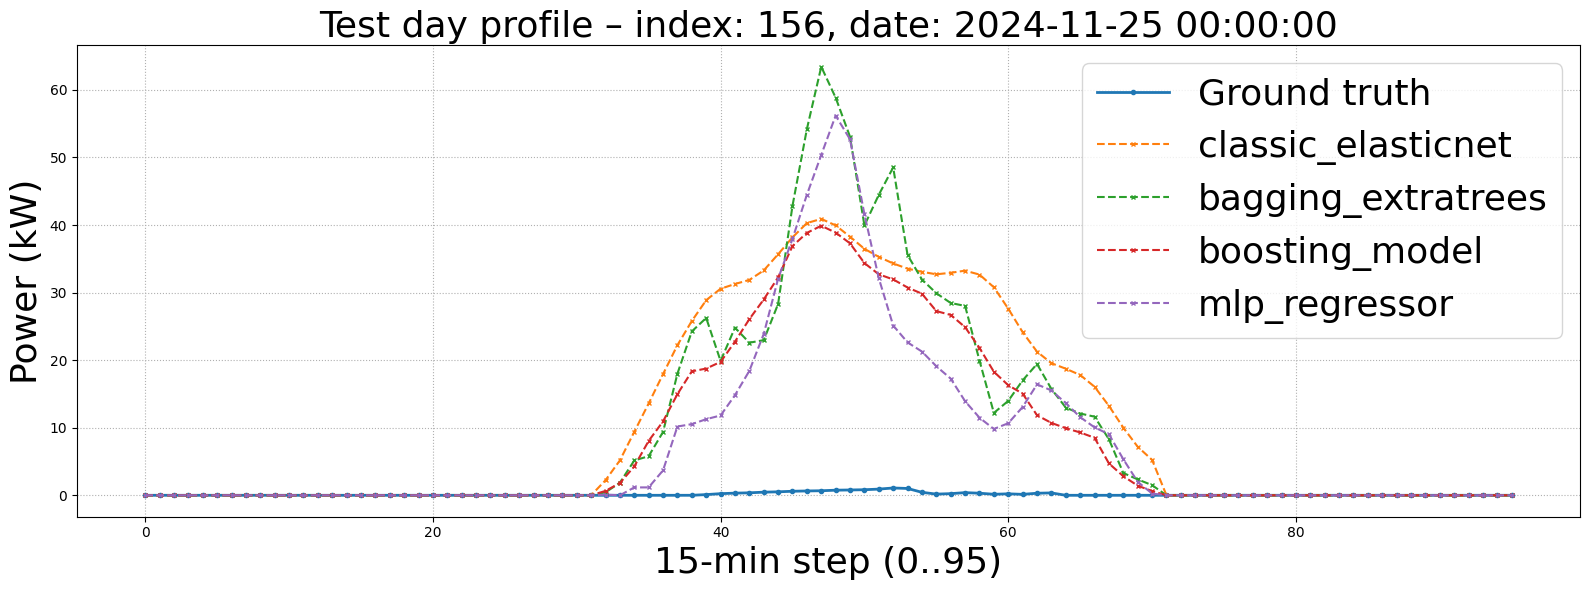

[Saved] Test day profile figure -> C:\Users\Admin\Desktop\Vedat\day_ahead_4models_outputs\figures\test_day_profile_CLASSIC_ML_20260112_101128_day156.png (+.pdf)


In [24]:
# ============================================================
# OUTPUT BLOCK (KOD-1 FORMAT) – CLASSIC ML (KOD-2)
#  - Outputs are saved into the SAME directory as KOD-1:
#      C:\Users\Admin\Desktop\Vedat\day_ahead_4models_outputs
#  - Filenames are DIFFERENT (CLASSIC_ML + RUN_ID) to avoid overwrite.
#
# Produces:
#  (1) metrics_overall_CLASSIC_ML_<RUN_ID>.csv   (ALL + DAY columns in one table like KOD-1)
#  (2) metrics_overall_daylight_CLASSIC_ML_<RUN_ID>.csv  (optional, if available)
#  (3) metrics_daily_CLASSIC_ML_<RUN_ID>_<model>.csv     (per model)
#  (4) best_model_CLASSIC_ML_<RUN_ID>.json      (in KOD-1 artifacts/)
#  (5) table figures (.png + .pdf)
#  (6) test day profile plot (.png + .pdf) + shows the plot
# ============================================================

# --- Target directory: SAME AS KOD-1 OUT_DIR (but different filenames) ---
OUT_DIR_KOD1 = r"C:\Users\Admin\Desktop\Vedat\day_ahead_4models_outputs"
ARTIFACT_DIR_KOD1 = os.path.join(OUT_DIR_KOD1, "artifacts")
FIG_DIR_KOD1 = os.path.join(OUT_DIR_KOD1, "figures")

os.makedirs(OUT_DIR_KOD1, exist_ok=True)
os.makedirs(ARTIFACT_DIR_KOD1, exist_ok=True)
os.makedirs(FIG_DIR_KOD1, exist_ok=True)

# --- RUN_ID fallback (if someone runs this block standalone) ---
RUN_ID_SAFE = globals().get("RUN_ID", datetime.now().strftime("%Y%m%d_%H%M%S"))
PREFIX = f"CLASSIC_ML_{RUN_ID_SAFE}"


# ============================================================
# 1) Build KOD-1 style overall summary: ALL + DAY in ONE table
# ============================================================

summary_rows = []
for model_name, m_all in metrics_overall_all.items():
    row = dict(m_all)

    m_day = None
    if isinstance(metrics_overall_day, dict):
        m_day = metrics_overall_day.get(model_name, None)

    row.update({
        "MSE_day":  float(m_day["MSE"])  if isinstance(m_day, dict) and ("MSE"  in m_day) else np.nan,
        "RMSE_day": float(m_day["RMSE"]) if isinstance(m_day, dict) and ("RMSE" in m_day) else np.nan,
        "MAE_day":  float(m_day["MAE"])  if isinstance(m_day, dict) and ("MAE"  in m_day) else np.nan,
        "R2_day":   float(m_day["R2"])   if isinstance(m_day, dict) and ("R2"   in m_day) else np.nan,
    })

    row["model"] = model_name
    summary_rows.append(row)

summary_df_k1fmt = pd.DataFrame(summary_rows).set_index("model").sort_values("RMSE")

print("\n======================================")
print("CLASSIC ML – TEST METRICS (OVERALL, DAY-AHEAD 96-STEP) [POST-PROCESSED]  (KOD-1 FORMAT)")
print("======================================")
print(summary_df_k1fmt)

# Save overall metrics CSV into KOD-1 directory with different name
summary_path_k1 = os.path.join(OUT_DIR_KOD1, f"metrics_overall_{PREFIX}.csv")
summary_df_k1fmt.to_csv(summary_path_k1)
print(f"[Saved] Overall metrics (KOD-1 dir) -> {summary_path_k1}")

# Best model by ALL-timestep RMSE (same rule as KOD-1)
BEST_MODEL_NAME = summary_df_k1fmt.index[0]
print(f"[Best] {BEST_MODEL_NAME}")

best_payload_k1 = {
    "best_model_name": BEST_MODEL_NAME,
    "run_id": RUN_ID_SAFE,
    "source": "classic_ml (code2)",
    "sorted_by": "RMSE (ALL timesteps, post-processed)",
    "boosting_backend": globals().get("boosting_backend", None),
    "daylight_weight": globals().get("DAYLIGHT_WEIGHT", None),
    "report_daylight_metrics": bool(globals().get("REPORT_DAYLIGHT_METRICS", False)),
}
best_path_k1 = os.path.join(ARTIFACT_DIR_KOD1, f"best_model_{PREFIX}.json")
with open(best_path_k1, "w", encoding="utf-8") as f:
    json.dump(best_payload_k1, f, ensure_ascii=False, indent=2)
print(f"[Saved] Best model payload (KOD-1 dir) -> {best_path_k1}")


# ============================================================
# 2) Save daily metrics per model into KOD-1 directory
# ============================================================

for model_name, df_daily in metrics_daily_all.items():
    daily_path_k1 = os.path.join(OUT_DIR_KOD1, f"metrics_daily_{PREFIX}_{model_name}.csv")
    df_daily.to_csv(daily_path_k1)

print(f"[Saved] Daily metrics (per model) into KOD-1 dir: {OUT_DIR_KOD1}")


# ============================================================
# 3) Save tables as FIGURES (PNG + PDF) for paper-ready usage
# ============================================================

def _save_df_as_table_figure(df, title, png_path, pdf_path, max_rows=30, round_n=3):
    df2 = df.copy()
    if df2.shape[0] > int(max_rows):
        df2 = df2.head(int(max_rows))

    # make it readable (numeric rounding)
    try:
        df2 = df2.round(int(round_n))
    except Exception:
        pass

    fig_h = max(2.5, 0.35 * (df2.shape[0] + 1))
    fig_w = max(10.0, 1.2 * (df2.shape[1] + 1))

    fig, ax = plt.subplots(figsize=(fig_w, fig_h))
    ax.axis("off")
    ax.set_title(title, fontsize=12, pad=12)

    tbl = ax.table(
        cellText=df2.values,
        rowLabels=df2.index.astype(str).tolist(),
        colLabels=df2.columns.astype(str).tolist(),
        loc="center"
    )
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(9)
    tbl.scale(1.0, 1.25)

    fig.tight_layout()
    fig.savefig(png_path, dpi=300, bbox_inches="tight")
    fig.savefig(pdf_path, dpi=300, bbox_inches="tight")
    plt.close(fig)

# Overall table figure
table_overall_png = os.path.join(FIG_DIR_KOD1, f"table_metrics_overall_{PREFIX}.png")
table_overall_pdf = os.path.join(FIG_DIR_KOD1, f"table_metrics_overall_{PREFIX}.pdf")
_save_df_as_table_figure(
    summary_df_k1fmt,
    title=f"Overall Test Metrics (Classic ML) – Post-Processed (RUN_ID={RUN_ID_SAFE})",
    png_path=table_overall_png,
    pdf_path=table_overall_pdf,
    max_rows=30,
    round_n=3
)
print(f"[Saved] Overall metrics TABLE figure -> {table_overall_png} (+.pdf)")

# Optional: daylight-only overall table (if available)
if isinstance(metrics_overall_day, dict) and len(metrics_overall_day) > 0:
    day_rows = []
    for model_name, m_day in metrics_overall_day.items():
        if not isinstance(m_day, dict):
            continue
        row = dict(m_day)
        row["model"] = model_name
        day_rows.append(row)

    if len(day_rows) > 0:
        summary_day_df = pd.DataFrame(day_rows).set_index("model").sort_values("RMSE")

        day_csv_k1 = os.path.join(OUT_DIR_KOD1, f"metrics_overall_daylight_{PREFIX}.csv")
        summary_day_df.to_csv(day_csv_k1)

        day_png_k1 = os.path.join(FIG_DIR_KOD1, f"table_metrics_overall_daylight_{PREFIX}.png")
        day_pdf_k1 = os.path.join(FIG_DIR_KOD1, f"table_metrics_overall_daylight_{PREFIX}.pdf")
        _save_df_as_table_figure(
            summary_day_df,
            title=f"Daylight-Only Test Metrics (Classic ML) – Post-Processed (RUN_ID={RUN_ID_SAFE})",
            png_path=day_png_k1,
            pdf_path=day_pdf_k1,
            max_rows=30,
            round_n=3
        )
        print(f"[Saved] Daylight-only overall metrics -> {day_csv_k1}")
        print(f"[Saved] Daylight-only TABLE figure -> {day_png_k1} (+.pdf)")


# ============================================================
# 4) Plot test-day profile (KOD-1 style) + SAVE PNG/PDF
# ============================================================

def plot_test_day_and_save(day_no, d_test, Y_test_orig, preds_by_model, prefix, fig_dir, model_list=None):
    if d_test is None or len(d_test) == 0:
        print("Empty test set, nothing to plot.")
        return

    if model_list is None:
        model_list = list(preds_by_model.keys())

    unique_days = np.unique(d_test)
    if day_no < 1 or day_no > len(unique_days):
        print(f"Invalid day_no={day_no}. There are {len(unique_days)} unique test days.")
        return

    day_label = unique_days[day_no - 1]
    idxs = np.where(d_test == day_label)[0]
    if len(idxs) == 0:
        print(f"No sample found for day {day_label}.")
        return

    y_true = np.asarray(Y_test_orig)[idxs].reshape(-1)

    plt.figure(figsize=(16, 6))
    plt.plot(y_true, label="Ground truth", marker="o", ms=3, linewidth=2)

    for model_name in model_list:
        if model_name not in preds_by_model:
            continue
        y_pred_day = np.asarray(preds_by_model[model_name])[idxs].reshape(-1)
        plt.plot(y_pred_day, label=f"{model_name}", linestyle="--", marker="x", ms=3)

    plt.title(f"Test day profile – index: {day_no}, date: {day_label}", fontsize=26)
    plt.xlabel("15-min step (0..95)", fontsize=26)
    plt.ylabel("Power (kW)", fontsize=26)
    plt.grid(True, linestyle=":")
    plt.legend(fontsize=26)
    plt.tight_layout()

    png_path = os.path.join(fig_dir, f"test_day_profile_{prefix}_day{day_no}.png")
    pdf_path = os.path.join(fig_dir, f"test_day_profile_{prefix}_day{day_no}.pdf")
    plt.savefig(png_path, dpi=300, bbox_inches="tight")
    plt.savefig(pdf_path, dpi=300, bbox_inches="tight")
    plt.show()

    print(f"[Saved] Test day profile figure -> {png_path} (+.pdf)")

# Example plot (day 1)
Y_test_for_plot = y_test_orig_day.squeeze(-1)  # (N,96)
print("\nExample plot (KOD-1 format + save): plot_test_day_and_save(1, d_test, Y_test_for_plot, preds_by_model, ...)")
plot_test_day_and_save(156, d_test, Y_test_for_plot, preds_by_model, prefix=PREFIX, fig_dir=FIG_DIR_KOD1)



Example plot (KOD-1 format + save): plot_test_day_and_save(1, d_test, Y_test_for_plot, preds_by_model, ...)


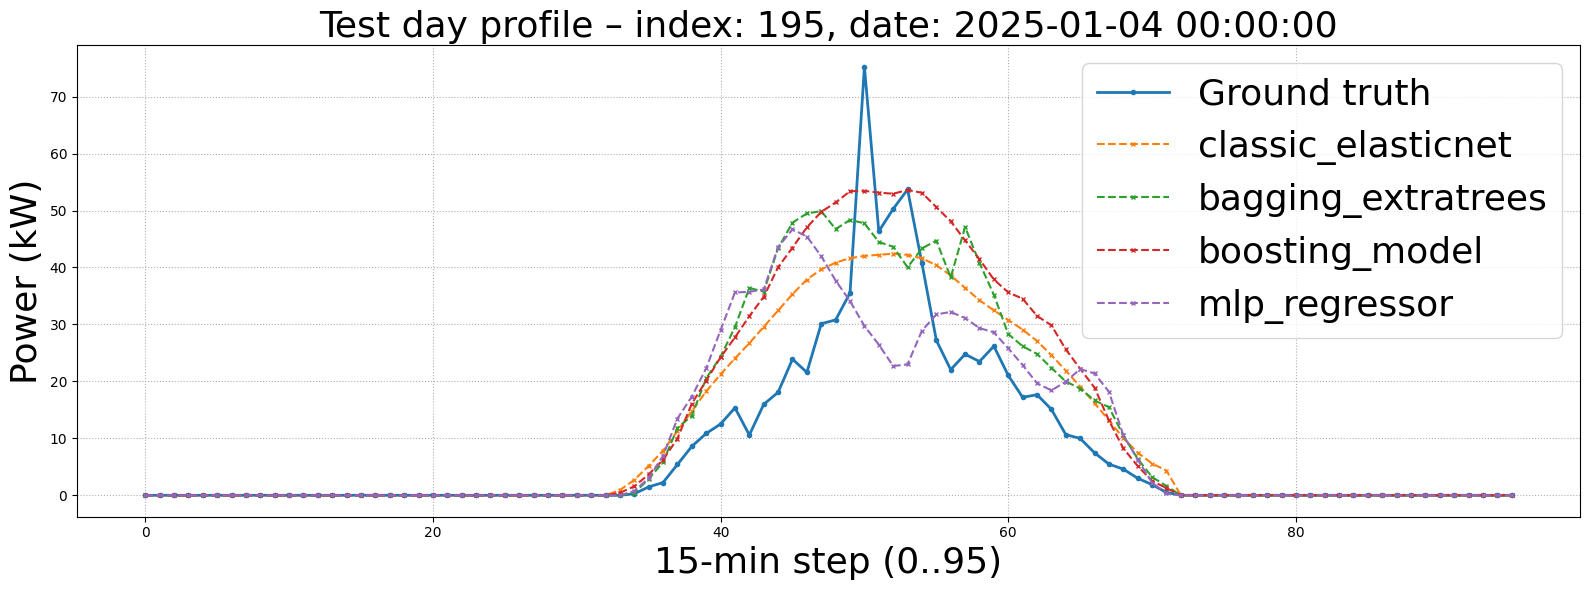

[Saved] Test day profile figure -> C:\Users\Admin\Desktop\Vedat\day_ahead_4models_outputs\figures\test_day_profile_CLASSIC_ML_20260112_101128_day195.png (+.pdf)


In [22]:
# Example plot (day 1)
Y_test_for_plot = y_test_orig_day.squeeze(-1)  # (N,96)
print("\nExample plot (KOD-1 format + save): plot_test_day_and_save(1, d_test, Y_test_for_plot, preds_by_model, ...)")
plot_test_day_and_save(195, d_test, Y_test_for_plot, preds_by_model, prefix=PREFIX, fig_dir=FIG_DIR_KOD1)


CLASSIC ML – TEST METRICS (OVERALL, DAY-AHEAD 96-STEP) [POST-PROCESSED] (KOD-1 FORMAT)
                           MSE       RMSE       MAE        R2     MSE_day  \
model                                                                       
boosting_model       90.841851   9.531099  4.327783  0.919413  183.481089   
bagging_extratrees   96.182006   9.807243  4.349754  0.914676  194.267482   
classic_elasticnet  109.377838  10.458386  5.183687  0.902970  220.921280   
mlp_regressor       111.026482  10.536910  4.622030  0.901508  224.251312   

                     RMSE_day    MAE_day    R2_day  
model                                               
boosting_model      13.545519   8.732036  0.843386  
bagging_extratrees  13.937987   8.776414  0.834180  
classic_elasticnet  14.863421  10.460846  0.811429  
mlp_regressor       14.975023   9.326374  0.808586  
[Saved] Overall metrics (KOD-1 dir) -> C:\Users\Admin\Desktop\Vedat\day_ahead_classic_ml_outputs\metrics_overall_CLASSIC_ML_2026011

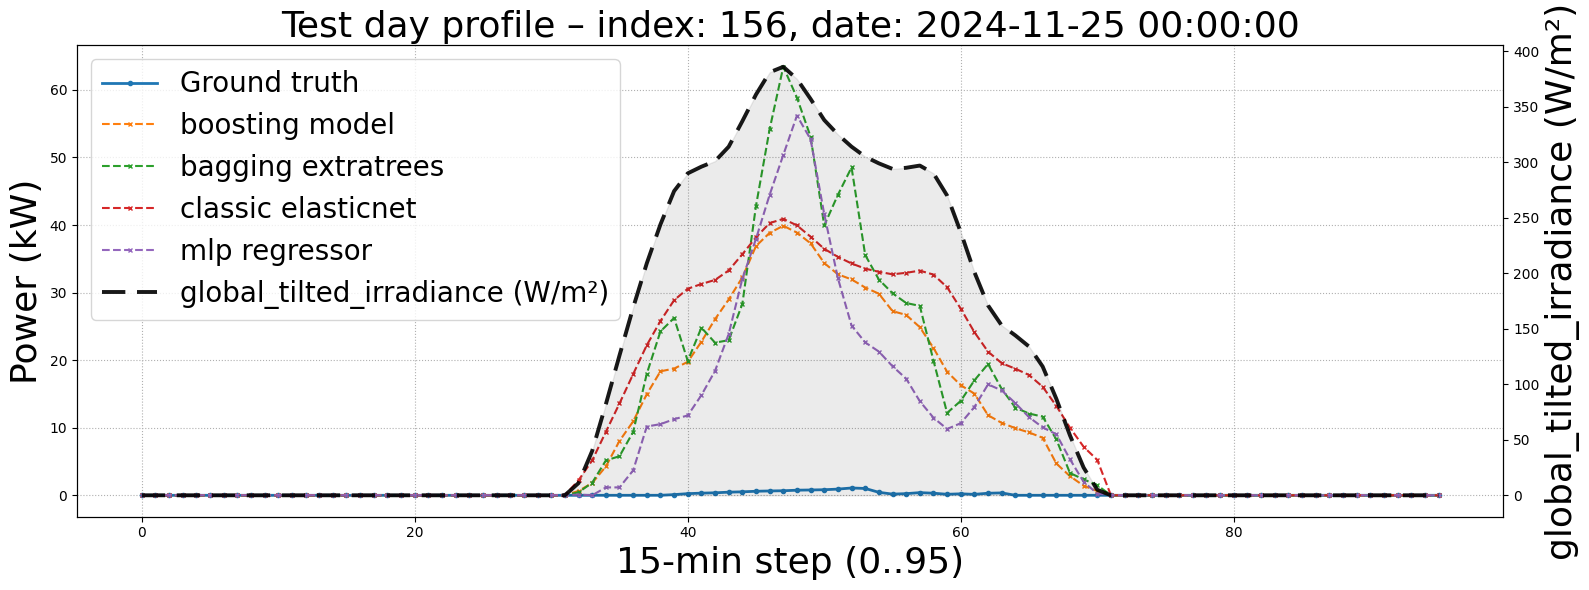

[Saved] Test day profile figure -> C:\Users\Admin\Desktop\Vedat\day_ahead_classic_ml_outputs\figures\test_day_profile_CLASSIC_ML_20260112_101128_day156.png (+.pdf)


In [33]:
# ============================================================
# OUTPUT BLOCK (KOD-1 FORMAT) – CLASSIC ML (KOD-2)  [REVISED v2]
#  - Same directory as KOD-1 (uses OUT_DIR if exists, else fallback path)
#  - Different filenames: CLASSIC_ML_<RUN_ID>
#
#  v2 FIXES (based on your log):
#   ✅ df_test datetime column not found -> now supports:
#      - datetime as index (DatetimeIndex)
#      - wider datetime column name detection (case-insensitive + heuristics)
#      - optional manual overrides: DT_COL, GTI_COL
#   ✅ GTI is built and ALIGNED to d_test (N,96) via day-key mapping
#   ✅ Plot overlays GTI on 2nd axis when available (gti_name="global_tilted_irradiance (W/m²)")
# ============================================================

import os
import json
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# -----------------------------
# 0) Sanity checks (required inputs)
# -----------------------------
required_vars = ["metrics_overall_all", "metrics_daily_all"]
missing = [v for v in required_vars if v not in globals() or globals()[v] is None]
if missing:
    raise ValueError(f"Missing required variables in globals(): {missing}")

# -----------------------------
# 1) DIRECTORIES (same as KOD-1 if OUT_DIR exists; else fallback)
# -----------------------------
OUT_DIR_KOD1 = globals().get("OUT_DIR", r"C:\Users\Admin\Desktop\Vedat\day_ahead_4models_outputs")
ARTIFACT_DIR_KOD1 = os.path.join(OUT_DIR_KOD1, "artifacts")
FIG_DIR_KOD1 = os.path.join(OUT_DIR_KOD1, "figures")

os.makedirs(OUT_DIR_KOD1, exist_ok=True)
os.makedirs(ARTIFACT_DIR_KOD1, exist_ok=True)
os.makedirs(FIG_DIR_KOD1, exist_ok=True)

# -----------------------------
# 2) RUN_ID / PREFIX
# -----------------------------
RUN_ID_SAFE = globals().get("RUN_ID", datetime.now().strftime("%Y%m%d_%H%M%S"))
PREFIX = f"CLASSIC_ML_{RUN_ID_SAFE}"

# ------------------------------------------------------------
# Helpers
# ------------------------------------------------------------
def _get_first_global(names):
    for n in names:
        if n in globals() and globals()[n] is not None:
            return globals()[n], n
    return None, None

def _pretty_model_label(model_name: str) -> str:
    s = re.sub(r"^model\d+_", "", str(model_name))  # remove "modelX_"
    s = s.replace("_", " ")
    return s

def _day_key(val):
    """
    Normalize any day-like label to a stable key (YYYY-MM-DD if parseable),
    else fallback to str(val).
    """
    try:
        ts = pd.to_datetime(val, errors="raise")
        return ts.strftime("%Y-%m-%d")
    except Exception:
        return str(val)

def _find_gti_column(df: pd.DataFrame, preferred: str = None):
    if df is None or df.empty:
        return None

    if preferred and preferred in df.columns:
        return preferred

    # exact-ish candidates (case-insensitive)
    gti_candidates = [
        "global_tilted_irradiance (W/m²)",
        "global_tilted_irradiance (W/m2)",
        "global_tilted_irradiance",
        "gti",
        "GTI",
    ]

    cols_lower_map = {str(c).lower(): c for c in df.columns}
    for c in gti_candidates:
        if str(c).lower() in cols_lower_map:
            return cols_lower_map[str(c).lower()]

    # substring heuristics
    for c in df.columns:
        cl = str(c).lower()
        if "global_tilted_irradiance" in cl:
            return c
        if ("tilted" in cl and "irradiance" in cl):
            return c
        if ("gti" in cl):
            return c
        # optional solar synonyms (safe)
        if ("poa" in cl and "irradiance" in cl):
            return c

    return None

def _find_datetime_series(df: pd.DataFrame, preferred: str = None):
    """
    Returns (dt_series, dt_source_name) or (None, None).
    Supports:
      - DatetimeIndex
      - explicit preferred column
      - common datetime column names (case-insensitive)
      - datetime dtype columns
      - heuristic parse of string/object columns that contain date/time keywords
    """
    if df is None or df.empty:
        return None, None

    # 1) datetime in index
    if isinstance(df.index, pd.DatetimeIndex):
        return df.index.to_series(), "<index:DatetimeIndex>"

    # 2) preferred override
    if preferred and preferred in df.columns:
        s = pd.to_datetime(df[preferred], errors="coerce")
        if s.notna().mean() >= 0.80:
            return s, preferred

    # 3) common name candidates (case-insensitive)
    name_candidates = [
        "ds", "datetime", "timestamp", "time", "date_time",
        "date", "dt", "tarih", "zaman",
        "local_time", "utc_time", "datetime_local", "datetime_utc",
    ]
    for cand in name_candidates:
        for col in df.columns:
            if str(col).lower() == cand:
                s = pd.to_datetime(df[col], errors="coerce")
                if s.notna().mean() >= 0.80:
                    return s, col

    # 4) datetime dtype columns
    dt_cols = []
    for col in df.columns:
        try:
            if np.issubdtype(df[col].dtype, np.datetime64):
                dt_cols.append(col)
        except Exception:
            pass
    if dt_cols:
        col = dt_cols[0]
        s = pd.to_datetime(df[col], errors="coerce")
        if s.notna().mean() >= 0.80:
            return s, col

    # 5) heuristic parse: object/string cols with date/time keywords
    keyword_cols = []
    for col in df.columns:
        cl = str(col).lower()
        if any(k in cl for k in ["date", "time", "stamp", "ts", "datetime", "tarih", "zaman"]):
            keyword_cols.append(col)

    # restrict to object-like columns to avoid accidental epoch parsing
    keyword_cols = [c for c in keyword_cols if df[c].dtype == object or "string" in str(df[c].dtype).lower()]

    best_col, best_s, best_ratio = None, None, 0.0
    for col in keyword_cols:
        s = pd.to_datetime(df[col], errors="coerce")
        ratio = float(s.notna().mean())
        if ratio > best_ratio:
            best_ratio, best_col, best_s = ratio, col, s

    if best_s is not None and best_ratio >= 0.80:
        return best_s, best_col

    return None, None


# ============================================================
# 1) Build KOD-1 style overall summary: ALL + DAY in ONE table
# ============================================================

summary_rows = []
for model_name, m_all in metrics_overall_all.items():
    row = dict(m_all)

    m_day = None
    if isinstance(globals().get("metrics_overall_day", None), dict):
        m_day = metrics_overall_day.get(model_name, None)

    row.update({
        "MSE_day":  float(m_day["MSE"])  if isinstance(m_day, dict) and ("MSE"  in m_day) else np.nan,
        "RMSE_day": float(m_day["RMSE"]) if isinstance(m_day, dict) and ("RMSE" in m_day) else np.nan,
        "MAE_day":  float(m_day["MAE"])  if isinstance(m_day, dict) and ("MAE"  in m_day) else np.nan,
        "R2_day":   float(m_day["R2"])   if isinstance(m_day, dict) and ("R2"   in m_day) else np.nan,
    })

    row["model"] = model_name
    summary_rows.append(row)

summary_df_k1fmt = pd.DataFrame(summary_rows).set_index("model").sort_values("RMSE")

print("\n======================================")
print("CLASSIC ML – TEST METRICS (OVERALL, DAY-AHEAD 96-STEP) [POST-PROCESSED] (KOD-1 FORMAT)")
print("======================================")
print(summary_df_k1fmt)

summary_path_k1 = os.path.join(OUT_DIR_KOD1, f"metrics_overall_{PREFIX}.csv")
summary_df_k1fmt.to_csv(summary_path_k1)
print(f"[Saved] Overall metrics (KOD-1 dir) -> {summary_path_k1}")

BEST_MODEL_NAME = summary_df_k1fmt.index[0]
print(f"[Best] {BEST_MODEL_NAME}")

best_payload_k1 = {
    "best_model_name": BEST_MODEL_NAME,
    "run_id": RUN_ID_SAFE,
    "source": "classic_ml (code2 revised v2 w/ GTI)",
    "sorted_by": "RMSE (ALL timesteps, post-processed)",
    "boosting_backend": globals().get("boosting_backend", None),
    "daylight_weight": globals().get("DAYLIGHT_WEIGHT", None),
    "report_daylight_metrics": bool(globals().get("REPORT_DAYLIGHT_METRICS", False)),
}
best_path_k1 = os.path.join(ARTIFACT_DIR_KOD1, f"best_model_{PREFIX}.json")
with open(best_path_k1, "w", encoding="utf-8") as f:
    json.dump(best_payload_k1, f, ensure_ascii=False, indent=2)
print(f"[Saved] Best model payload (KOD-1 dir) -> {best_path_k1}")


# ============================================================
# 2) Save daily metrics per model into KOD-1 directory
# ============================================================

for model_name, df_daily in metrics_daily_all.items():
    daily_path_k1 = os.path.join(OUT_DIR_KOD1, f"metrics_daily_{PREFIX}_{model_name}.csv")
    df_daily.to_csv(daily_path_k1)

print(f"[Saved] Daily metrics (per model) into KOD-1 dir: {OUT_DIR_KOD1}")


# ============================================================
# 3) Save tables as FIGURES (PNG + PDF)
# ============================================================

def _save_df_as_table_figure(df, title, png_path, pdf_path, max_rows=30, round_n=3):
    df2 = df.copy()
    if df2.shape[0] > int(max_rows):
        df2 = df2.head(int(max_rows))

    try:
        df2 = df2.round(int(round_n))
    except Exception:
        pass

    fig_h = max(2.5, 0.35 * (df2.shape[0] + 1))
    fig_w = max(10.0, 1.2 * (df2.shape[1] + 1))

    fig, ax = plt.subplots(figsize=(fig_w, fig_h))
    ax.axis("off")
    ax.set_title(title, fontsize=12, pad=12)

    tbl = ax.table(
        cellText=df2.values,
        rowLabels=df2.index.astype(str).tolist(),
        colLabels=df2.columns.astype(str).tolist(),
        loc="center"
    )
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(9)
    tbl.scale(1.0, 1.25)

    fig.tight_layout()
    fig.savefig(png_path, dpi=300, bbox_inches="tight")
    fig.savefig(pdf_path, dpi=300, bbox_inches="tight")
    plt.close(fig)

table_overall_png = os.path.join(FIG_DIR_KOD1, f"table_metrics_overall_{PREFIX}.png")
table_overall_pdf = os.path.join(FIG_DIR_KOD1, f"table_metrics_overall_{PREFIX}.pdf")
_save_df_as_table_figure(
    summary_df_k1fmt,
    title=f"Overall Test Metrics (Classic ML) – Post-Processed (RUN_ID={RUN_ID_SAFE})",
    png_path=table_overall_png,
    pdf_path=table_overall_pdf,
    max_rows=30,
    round_n=3
)
print(f"[Saved] Overall metrics TABLE figure -> {table_overall_png} (+.pdf)")

if isinstance(globals().get("metrics_overall_day", None), dict) and len(metrics_overall_day) > 0:
    day_rows = []
    for model_name, m_day in metrics_overall_day.items():
        if not isinstance(m_day, dict):
            continue
        row = dict(m_day)
        row["model"] = model_name
        day_rows.append(row)

    if len(day_rows) > 0:
        summary_day_df = pd.DataFrame(day_rows).set_index("model").sort_values("RMSE")

        day_csv_k1 = os.path.join(OUT_DIR_KOD1, f"metrics_overall_daylight_{PREFIX}.csv")
        summary_day_df.to_csv(day_csv_k1)

        day_png_k1 = os.path.join(FIG_DIR_KOD1, f"table_metrics_overall_daylight_{PREFIX}.png")
        day_pdf_k1 = os.path.join(FIG_DIR_KOD1, f"table_metrics_overall_daylight_{PREFIX}.pdf")
        _save_df_as_table_figure(
            summary_day_df,
            title=f"Daylight-Only Test Metrics (Classic ML) – Post-Processed (RUN_ID={RUN_ID_SAFE})",
            png_path=day_png_k1,
            pdf_path=day_pdf_k1,
            max_rows=30,
            round_n=3
        )
        print(f"[Saved] Daylight-only overall metrics -> {day_csv_k1}")
        print(f"[Saved] Daylight-only TABLE figure -> {day_png_k1} (+.pdf)")


# ============================================================
# 4) Plot test-day profile + SAVE PNG/PDF (Power + optional GTI)
# ============================================================

def plot_test_day_and_save(
    day_no,
    d_test,
    Y_test_orig_2d,
    preds_by_model_2d,
    prefix,
    fig_dir,
    model_list=None,
    gti_test_2d=None,  # (N,96) optional
    gti_name="global_tilted_irradiance (W/m²)",
):
    if d_test is None or len(d_test) == 0:
        print("Empty test set, nothing to plot.")
        return

    if model_list is None:
        model_list = list(preds_by_model_2d.keys())

    unique_days = np.unique(d_test)
    if day_no < 1 or day_no > len(unique_days):
        print(f"Invalid day_no={day_no}. There are {len(unique_days)} unique test days.")
        return

    day_label = unique_days[day_no - 1]
    idxs = np.where(d_test == day_label)[0]
    if len(idxs) == 0:
        print(f"No sample found for day {day_label}.")
        return

    y_true = np.asarray(Y_test_orig_2d)[idxs].reshape(-1)

    fig, ax1 = plt.subplots(figsize=(16, 6))

    # Power (kW) - left axis
    ax1.plot(y_true, label="Ground truth", marker="o", ms=3, linewidth=2)

    for model_name in model_list:
        if model_name not in preds_by_model_2d:
            continue
        y_pred_day = np.asarray(preds_by_model_2d[model_name])[idxs].reshape(-1)
        ax1.plot(
            y_pred_day,
            label=_pretty_model_label(model_name),
            linestyle="--",
            marker="x",
            ms=3
        )

    ax1.set_title(f"Test day profile – index: {day_no}, date: {day_label}", fontsize=26)
    ax1.set_xlabel("15-min step (0..95)", fontsize=26)
    ax1.set_ylabel("Power (kW)", fontsize=26)
    ax1.grid(True, linestyle=":")

    # GTI (W/m²) - right axis (optional)
    ax2 = None
    if gti_test_2d is not None:
        gti_day = np.asarray(gti_test_2d)[idxs].reshape(-1)

        # If GTI exists but this day is missing (all NaN), skip overlay
        if np.all(np.isnan(gti_day)):
            print("[Warn] GTI matrix exists but this day has no GTI values -> plotting WITHOUT GTI overlay for this day.")
        else:
            ax2 = ax1.twinx()
            x = np.arange(len(gti_day))

            ax2.fill_between(
                x, 0, gti_day,
                color="black",
                alpha=0.08,
                zorder=0
            )

            ax2.plot(
                gti_day,
                label=gti_name,
                color="black",
                linestyle=(0, (6, 3)),
                linewidth=2.8,
                alpha=0.9,
                zorder=1
            )

            ax2.set_ylabel(gti_name, fontsize=26)
            ax2.tick_params(axis="y", colors="black")
            ax2.spines["right"].set_color("black")

    # Single combined legend
    h1, l1 = ax1.get_legend_handles_labels()
    if ax2 is not None:
        h2, l2 = ax2.get_legend_handles_labels()
        ax1.legend(h1 + h2, l1 + l2, fontsize=20, loc="best")
    else:
        ax1.legend(fontsize=20, loc="best")

    fig.tight_layout()

    png_path = os.path.join(fig_dir, f"test_day_profile_{prefix}_day{day_no}.png")
    pdf_path = os.path.join(fig_dir, f"test_day_profile_{prefix}_day{day_no}.pdf")
    fig.savefig(png_path, dpi=300, bbox_inches="tight")
    fig.savefig(pdf_path, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close(fig)

    print(f"[Saved] Test day profile figure -> {png_path} (+.pdf)")


# ============================================================
# 5) Prepare GTI array (N,96) ROBUSTLY (KOD-1 style) + ALIGN to d_test
# ============================================================

gti_test_2d = globals().get("gti_test_2d", None)

DT_COL_OVERRIDE = globals().get("DT_COL", None)   # optional manual override
GTI_COL_OVERRIDE = globals().get("GTI_COL", None) # optional manual override

if gti_test_2d is None:
    # Try feature tensor/array path (3D preferred)
    Xcand, Xname = _get_first_global([
        "X_test_3d", "X_test", "x_test", "X_te", "X_test_seq", "X_test_scaled", "X_test_final"
    ])

    Fcand, Fname = _get_first_global([
        "feature_names", "FEATURE_NAMES", "feature_cols", "FEATURE_COLS",
        "selected_features", "SELECTED_FEATURES"
    ])

    if Fcand is not None and not isinstance(Fcand, (list, tuple)):
        try:
            Fcand = list(Fcand)
        except Exception:
            pass

    gti_candidates = [
        "global_tilted_irradiance (W/m²)",
        "global_tilted_irradiance (W/m2)",
        "global_tilted_irradiance",
        "gti",
        "GTI",
    ]

    if (Xcand is not None) and (Fcand is not None):
        X = np.asarray(Xcand)
        feature_names = list(Fcand)

        gti_idx = None
        for c in gti_candidates:
            if c in feature_names:
                gti_idx = feature_names.index(c)
                break

        if gti_idx is None:
            print(f"[Warn] GTI feature not found in {Fname}. Example features: {feature_names[:10]}")
        else:
            if X.ndim == 3:
                gti_test_2d = X[:, :, gti_idx]
                print(f"[Info] GTI extracted from {Xname} (3D) using '{feature_names[gti_idx]}' (idx={gti_idx})")
            elif X.ndim == 2:
                N = X.shape[0]
                if X.shape[1] % 96 == 0:
                    F = X.shape[1] // 96
                    if gti_idx < F:
                        X3 = X.reshape(N, 96, F)
                        gti_test_2d = X3[:, :, gti_idx]
                        print(f"[Info] GTI extracted from {Xname} (2D->3D reshape) using '{feature_names[gti_idx]}'")
                    else:
                        print(f"[Warn] gti_idx={gti_idx} >= F={F} after reshape. Check feature ordering.")
                else:
                    print(f"[Warn] {Xname} is 2D but not divisible by 96 -> cannot reshape safely. Shape={X.shape}")
            else:
                print(f"[Warn] {Xname} unexpected ndim={X.ndim}. Shape={X.shape}")

    # Fallback: build from df_test (15-min rows) and ALIGN to d_test
    if gti_test_2d is None:
        dfcand, dfname = _get_first_global([
            "df_test", "test_df", "df_te", "df_test_15min", "df_test_15m", "df_test_15"
        ])

        if dfcand is not None:
            df_test = dfcand.copy()

            # find GTI column
            gti_col = _find_gti_column(df_test, preferred=GTI_COL_OVERRIDE)
            if gti_col is None:
                print(f"[Warn] {dfname} found but GTI column not found. Example columns: {list(df_test.columns)[:25]}")
            else:
                # find datetime series (column or index)
                dt_series, dt_source = _find_datetime_series(df_test, preferred=DT_COL_OVERRIDE)

                if dt_series is None:
                    # last-resort: if df_test length matches N*96, reshape directly (assumes correct order)
                    if ("d_test" in globals()) and (globals()["d_test"] is not None):
                        N = len(d_test)
                        if len(df_test) == N * 96:
                            arr = df_test[gti_col].to_numpy()
                            gti_test_2d = arr.reshape(N, 96)
                            print(f"[Info] GTI built by reshape from {dfname}[{gti_col}] -> shape={gti_test_2d.shape} (no datetime needed)")
                        else:
                            print(f"[Warn] {dfname} found but datetime not detected, and len(df_test)={len(df_test)} != N*96={N*96}.")
                            print("       -> Set manual overrides: DT_COL='your_datetime_col' and/or GTI_COL='your_gti_col'")
                    else:
                        print(f"[Warn] {dfname} found but datetime not detected and d_test is missing -> cannot align GTI.")
                        print("       -> Set manual overrides: DT_COL='your_datetime_col' and/or GTI_COL='your_gti_col'")
                else:
                    # Build day -> gti vector map
                    dt_series = pd.to_datetime(dt_series, errors="coerce")
                    ok_ratio = float(dt_series.notna().mean())
                    if ok_ratio < 0.80:
                        print(f"[Warn] Detected datetime source {dt_source} but parse success is low ({ok_ratio:.2%}).")
                        print("       -> Set DT_COL manually (DT_COL='...') if needed.")
                    else:
                        # attach, sort, group
                        df_tmp = df_test.copy()
                        df_tmp["__dt__"] = dt_series
                        df_tmp = df_tmp.dropna(subset=["__dt__"]).sort_values("__dt__")
                        df_tmp["__day__"] = df_tmp["__dt__"].dt.floor("D")

                        gti_map = {}
                        for day, g in df_tmp.groupby("__day__"):
                            g = g.sort_values("__dt__")
                            arr = g[gti_col].to_numpy()
                            if len(arr) >= 96:
                                gti_map[_day_key(day)] = arr[:96]

                        if ("d_test" not in globals()) or (globals()["d_test"] is None):
                            print("[Warn] d_test missing -> cannot align df_test GTI to samples.")
                        else:
                            d_keys = [_day_key(x) for x in d_test]
                            gti_aligned = np.full((len(d_keys), 96), np.nan, dtype=float)

                            miss = 0
                            for i, k in enumerate(d_keys):
                                vec = gti_map.get(k, None)
                                if vec is not None:
                                    gti_aligned[i, :] = vec
                                else:
                                    miss += 1

                            gti_test_2d = gti_aligned
                            print(f"[Info] GTI built from {dfname}[{gti_col}] using datetime {dt_source} -> shape={gti_test_2d.shape}")
                            if miss > 0:
                                print(f"[Warn] GTI missing for {miss}/{len(d_keys)} test days (filled with NaN).")


if gti_test_2d is None:
    print("[Info] GTI still not available -> plotting WITHOUT GTI.")
else:
    arr = np.asarray(gti_test_2d)
    if arr.ndim != 2 or arr.shape[1] != 96:
        print(f"[Warn] gti_test_2d shape unexpected: {arr.shape} (expected (N,96))")


# ============================================================
# 6) Example plot (RMSE-sorted models) + save (with optional GTI)
# ============================================================

needed_for_plot = ["d_test", "preds_by_model"]
missing_plot = [v for v in needed_for_plot if v not in globals() or globals()[v] is None]

Ycand, Yname = _get_first_global(["y_test_orig_day", "y_test_orig", "Y_test_orig", "Y_test"])
if Ycand is None:
    missing_plot.append("y_test_orig_day (or y_test_orig)")

if missing_plot:
    print(f"[Warn] Missing for plotting: {sorted(set(missing_plot))} -> skipping plot call.")
else:
    models_sorted_for_plot = list(summary_df_k1fmt.index)

    Y_test_for_plot = np.asarray(Ycand)
    if Y_test_for_plot.ndim >= 3:
        try:
            Y_test_for_plot = Y_test_for_plot.squeeze(-1)
        except Exception:
            pass

    EXAMPLE_DAY_NO = 156  # change as needed

    print("\nExample plot (KOD-1 style + GTI if available): plot_test_day_and_save(EXAMPLE_DAY_NO, ...)")
    plot_test_day_and_save(
        day_no=EXAMPLE_DAY_NO,
        d_test=d_test,
        Y_test_orig_2d=Y_test_for_plot,
        preds_by_model_2d=preds_by_model,
        prefix=PREFIX,
        fig_dir=FIG_DIR_KOD1,
        model_list=models_sorted_for_plot,
        gti_test_2d=gti_test_2d,
        gti_name="global_tilted_irradiance (W/m²)",
    )


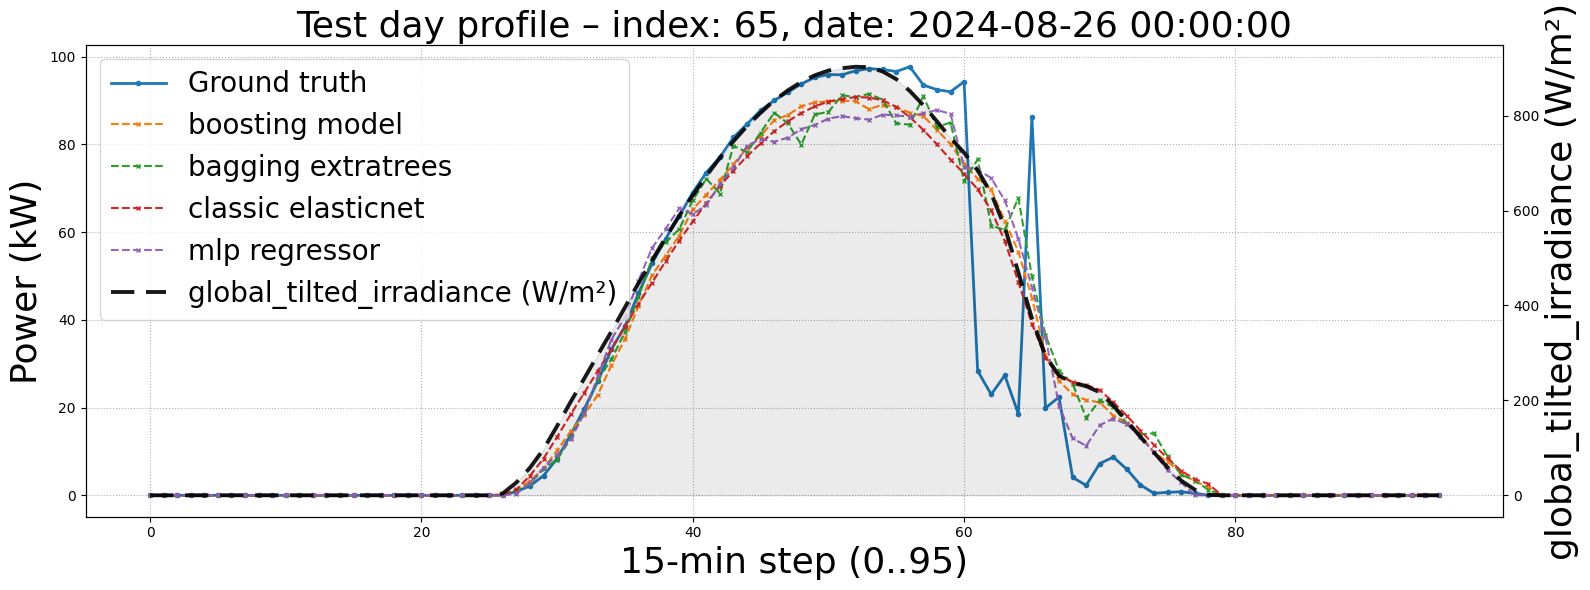

[Saved] Test day profile figure -> C:\Users\Admin\Desktop\Vedat\day_ahead_classic_ml_outputs\figures\test_day_profile_CLASSIC_ML_20260112_101128_day65.png (+.pdf)


In [37]:
plot_test_day_and_save(
        day_no=65,
        d_test=d_test,
        Y_test_orig_2d=Y_test_for_plot,
        preds_by_model_2d=preds_by_model,
        prefix=PREFIX,
        fig_dir=FIG_DIR_KOD1,
        model_list=models_sorted_for_plot,
        gti_test_2d=gti_test_2d,
        gti_name="global_tilted_irradiance (W/m²)",
    )